<center>
<h1> Credit Card Spend Prediction
</center>

###### Definition of Target and Outcome Window:
One of the global banks would like to understand what factors driving credit card spend are. The bank wants to use these insights to calculate credit limit. 


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - RFE/ VIF/ f-regression
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - MSE, RMSE, MAPE and R2 
    
###### Model Validation
    - Decile Analysis
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of toal spend as per the best model accuracy

In [1]:
# Importing Important libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp   
import scipy.stats as stats
import pandas_profiling

from sklearn.model_selection import train_test_split
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.formula.api as smp
import statsmodels.api as sm
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.decomposition import FactorAnalysis

In [2]:
# Creating utility UDF 

# Creating Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

# Creating Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

#### Dataset

In [3]:
credit_card =  pd.read_excel('E:/Python June 2020/Case study (Supervised learning)/Credit card spend/Data set.xlsx')
credit_card.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,...,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,...,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,...,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,...,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,...,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,...,1,0,1,0,1,0,0,0,1,0


In [4]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


#### Data Analysis

In [5]:
# variable columns
credit_card.columns.tolist()

['custid',
 'region',
 'townsize',
 'gender',
 'age',
 'agecat',
 'birthmonth',
 'ed',
 'edcat',
 'jobcat',
 'union',
 'employ',
 'empcat',
 'retire',
 'income',
 'lninc',
 'inccat',
 'debtinc',
 'creddebt',
 'lncreddebt',
 'othdebt',
 'lnothdebt',
 'default',
 'jobsat',
 'marital',
 'spoused',
 'spousedcat',
 'reside',
 'pets',
 'pets_cats',
 'pets_dogs',
 'pets_birds',
 'pets_reptiles',
 'pets_small',
 'pets_saltfish',
 'pets_freshfish',
 'homeown',
 'hometype',
 'address',
 'addresscat',
 'cars',
 'carown',
 'cartype',
 'carvalue',
 'carcatvalue',
 'carbought',
 'carbuy',
 'commute',
 'commutecat',
 'commutetime',
 'commutecar',
 'commutemotorcycle',
 'commutecarpool',
 'commutebus',
 'commuterail',
 'commutepublic',
 'commutebike',
 'commutewalk',
 'commutenonmotor',
 'telecommute',
 'reason',
 'polview',
 'polparty',
 'polcontrib',
 'vote',
 'card',
 'cardtype',
 'cardbenefit',
 'cardfee',
 'cardtenure',
 'cardtenurecat',
 'card2',
 'card2type',
 'card2benefit',
 'card2fee',
 'car

In [6]:
# data dimensions
credit_card.shape

(5000, 130)

#### Univariate Analysis

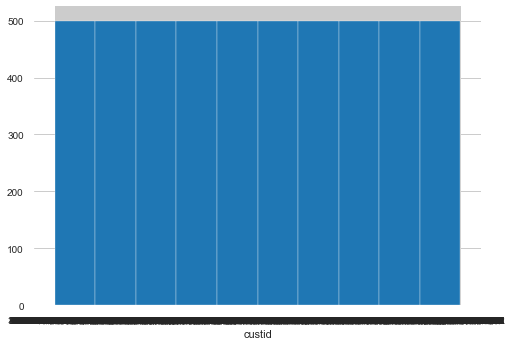

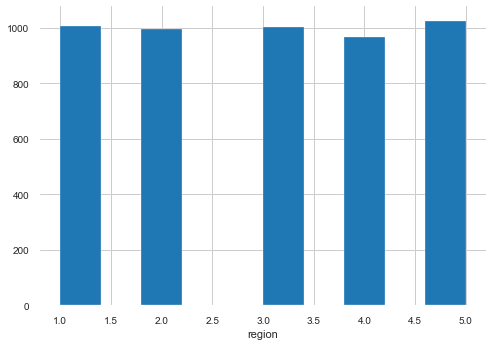

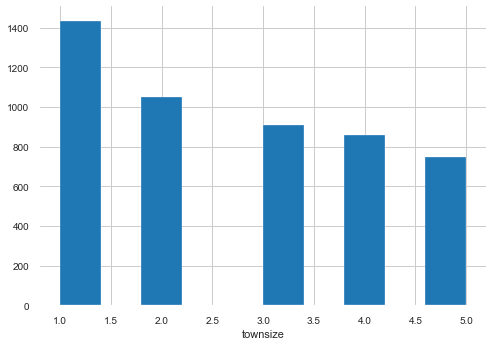

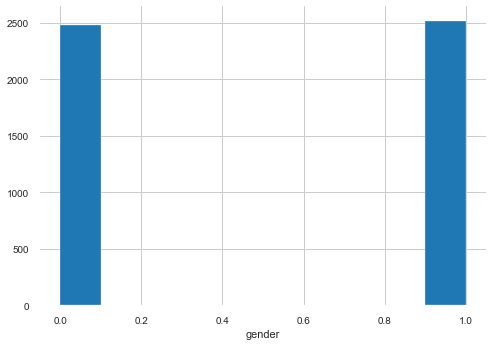

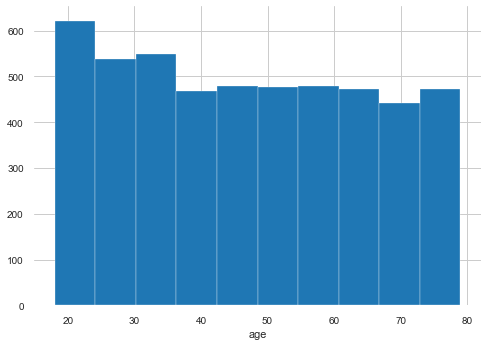

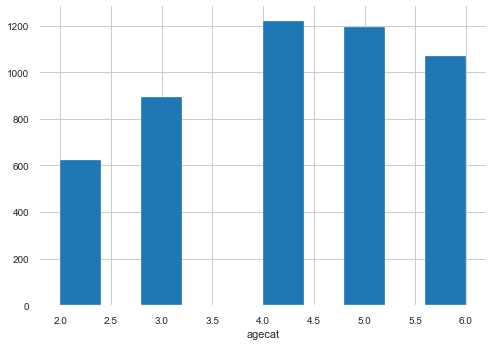

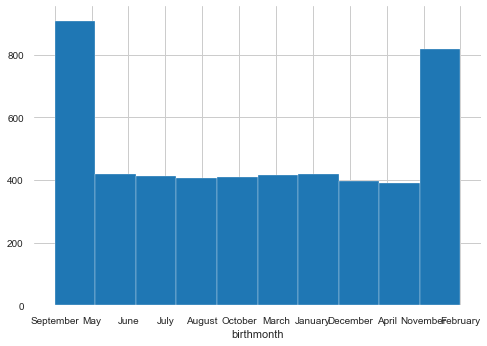

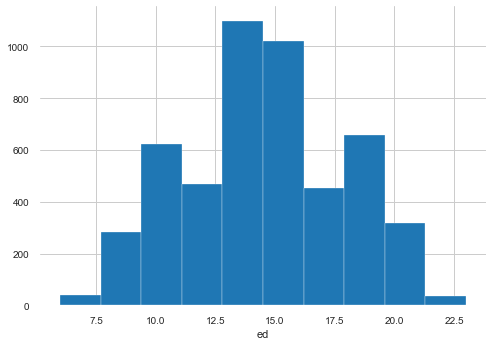

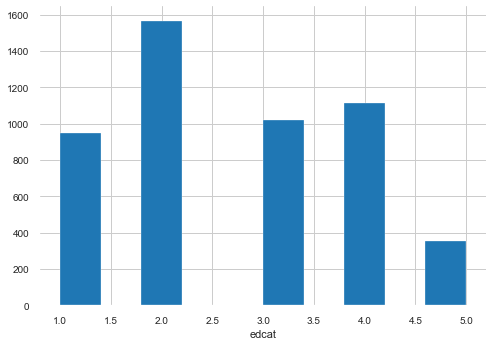

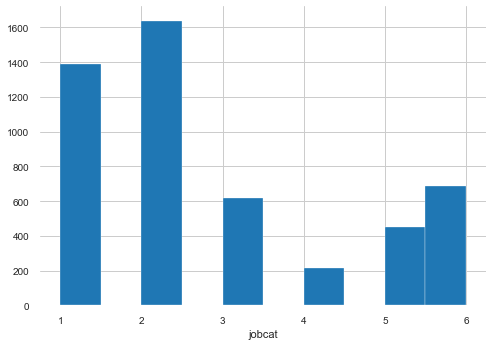

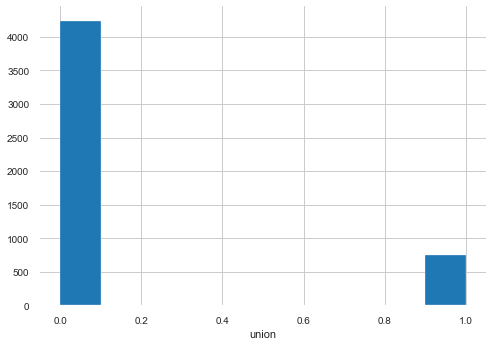

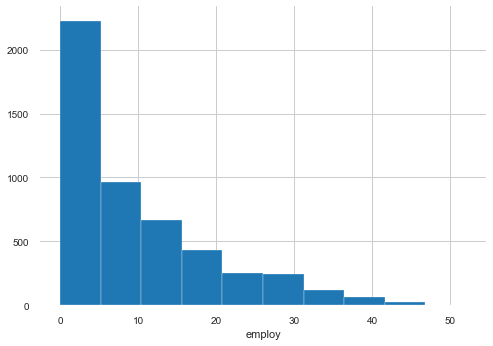

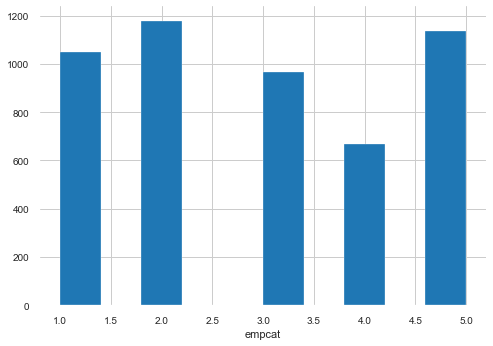

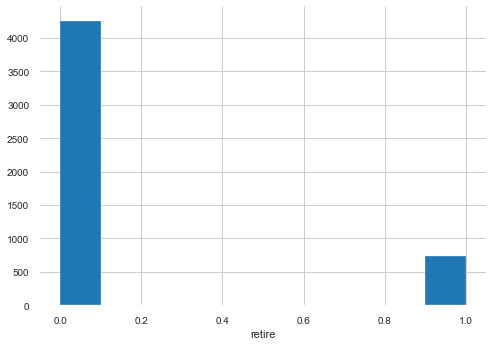

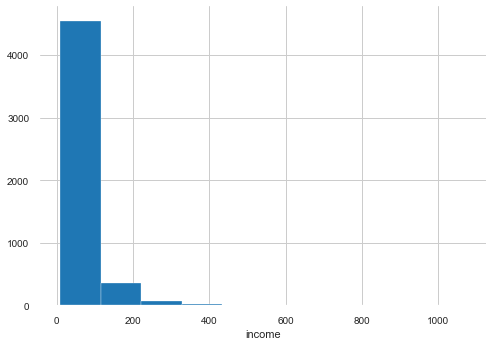

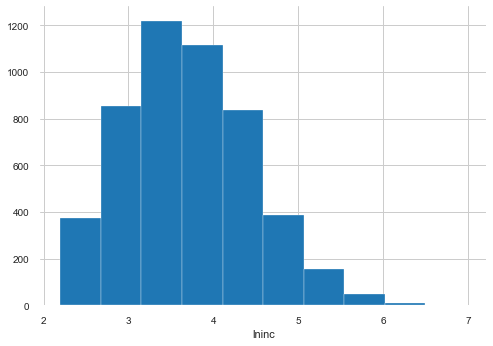

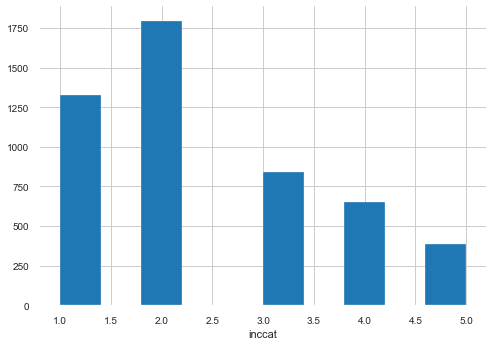

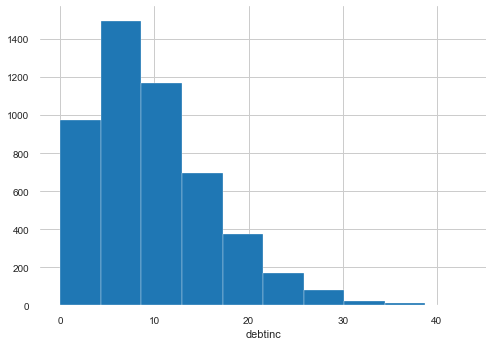

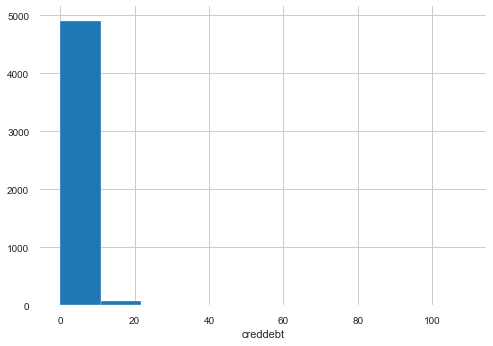

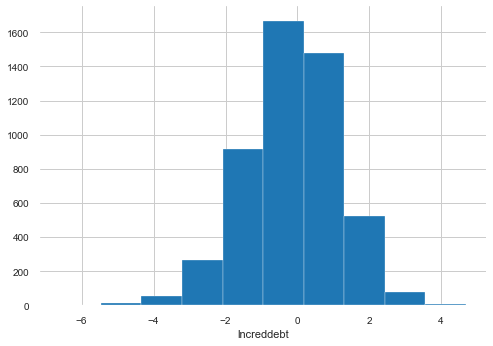

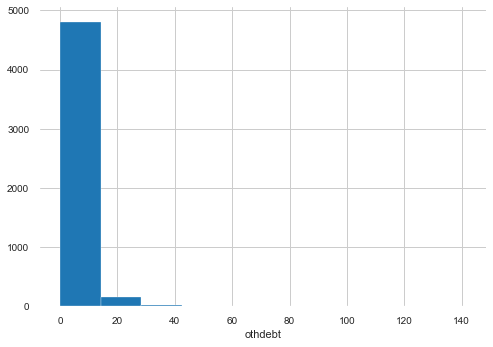

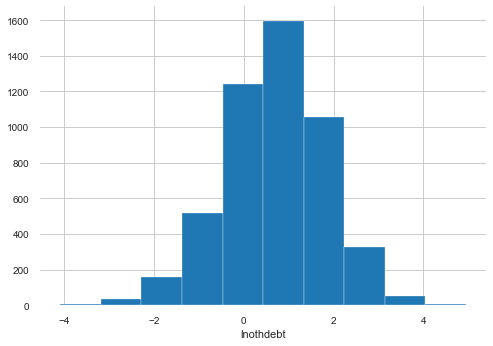

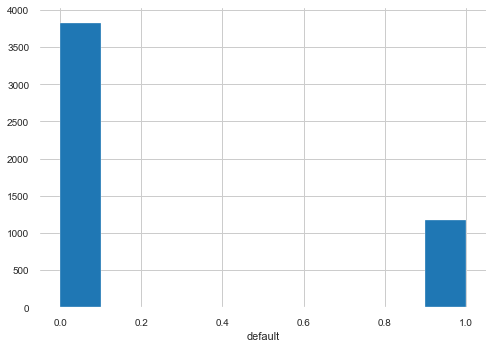

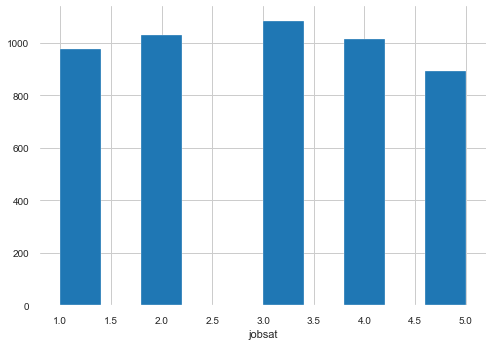

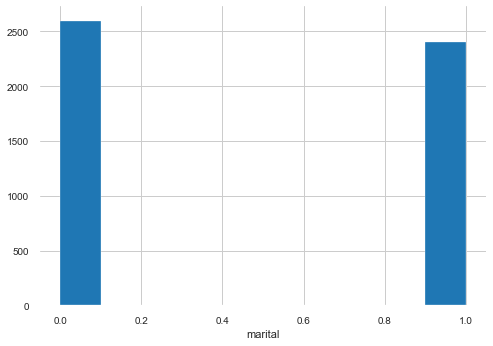

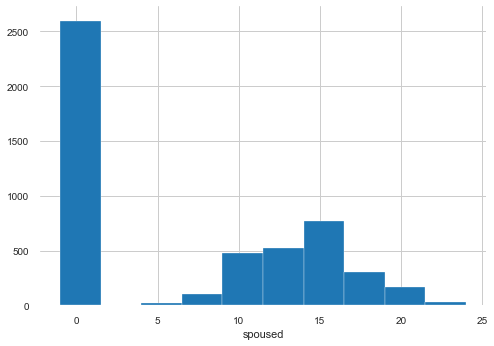

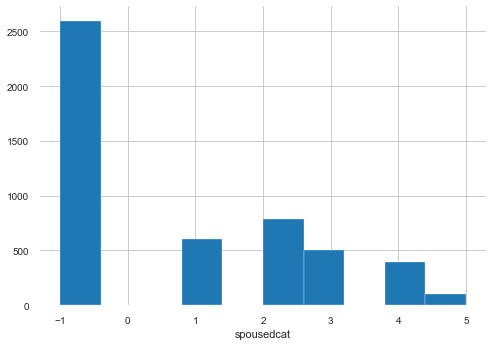

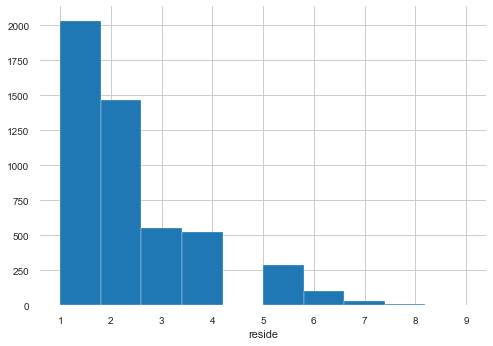

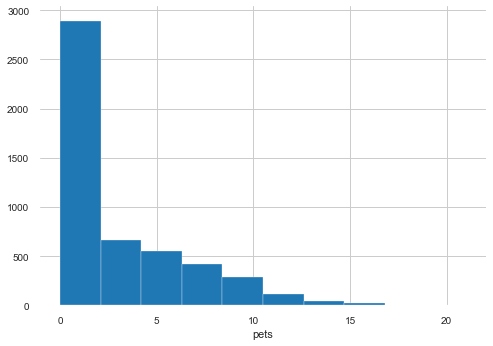

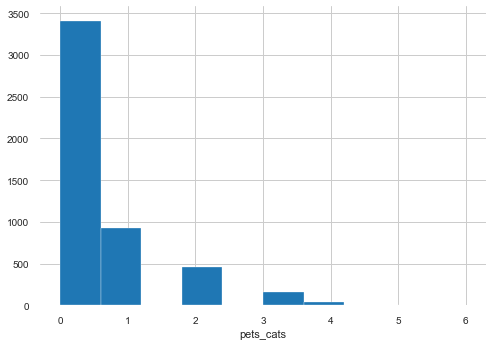

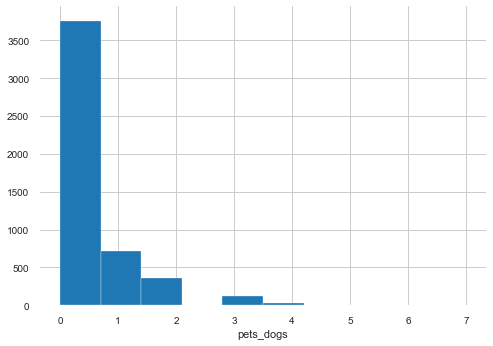

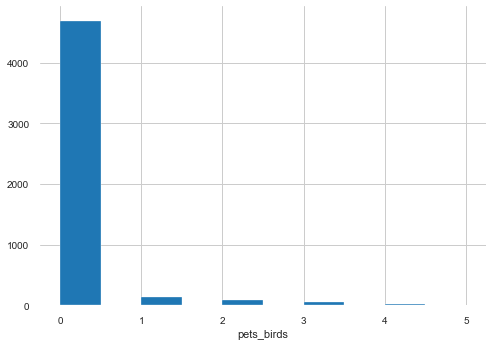

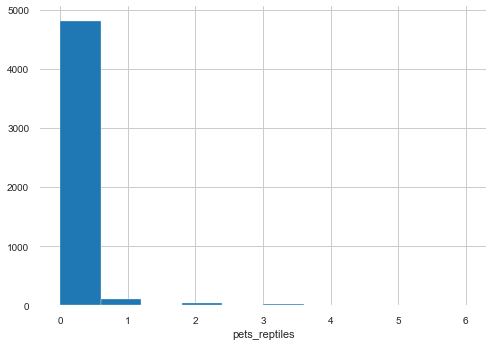

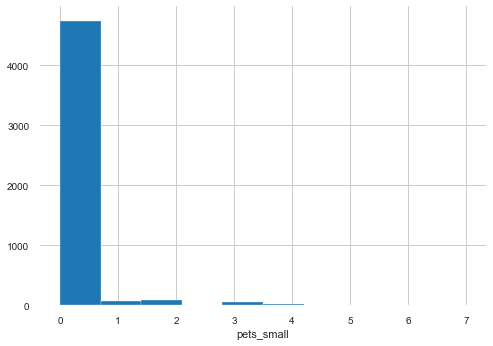

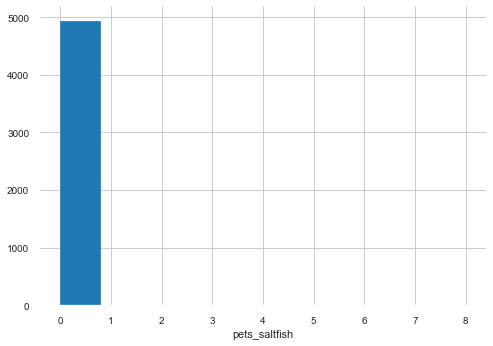

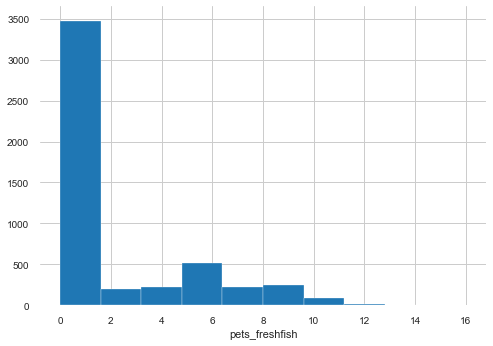

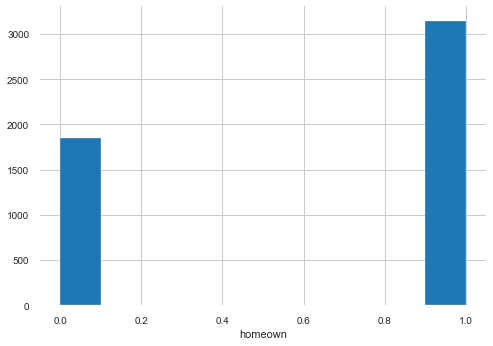

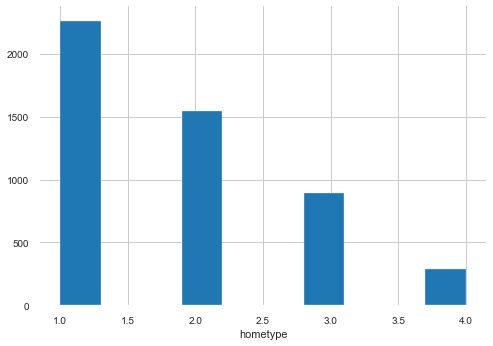

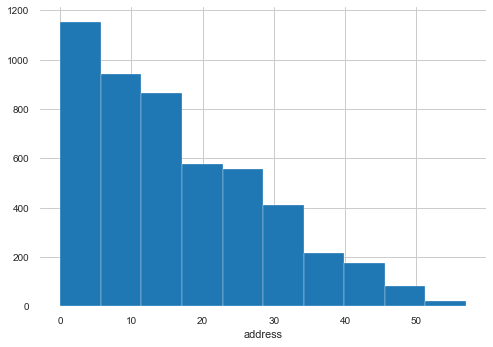

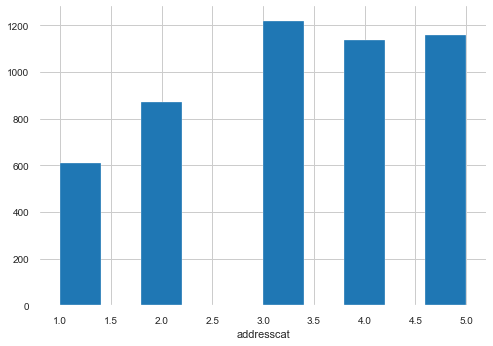

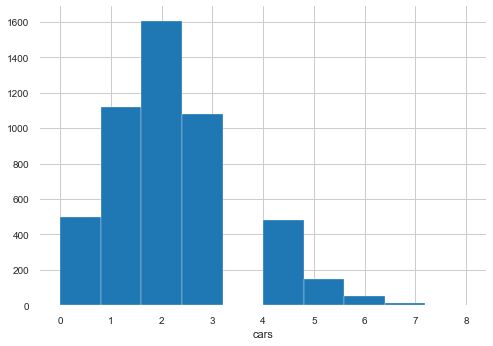

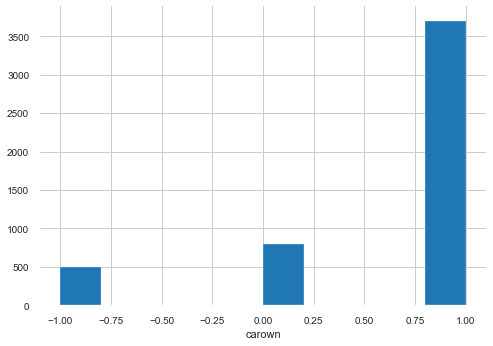

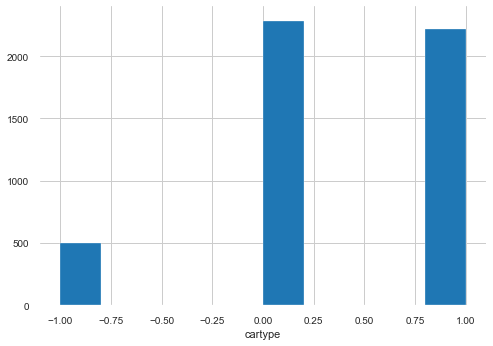

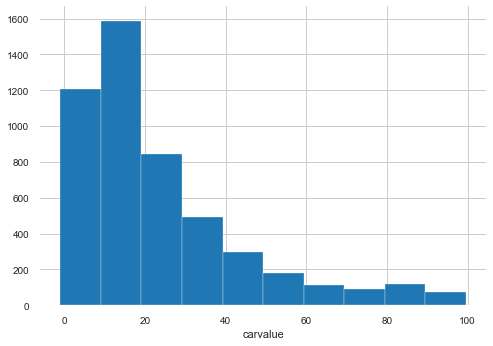

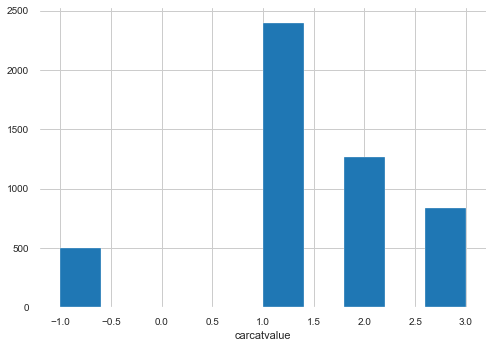

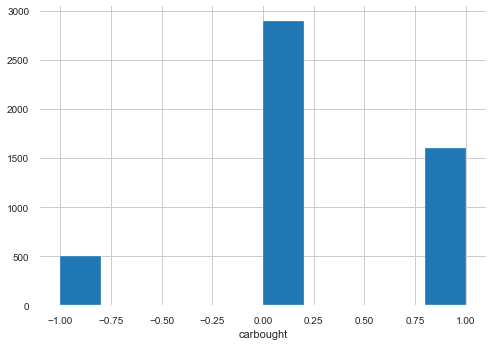

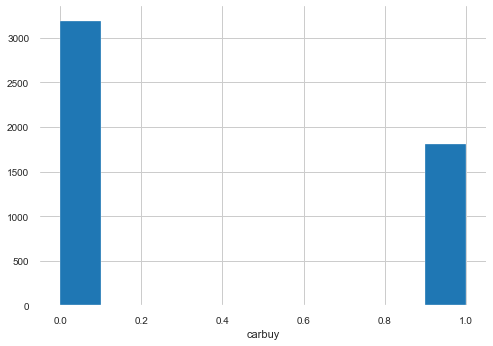

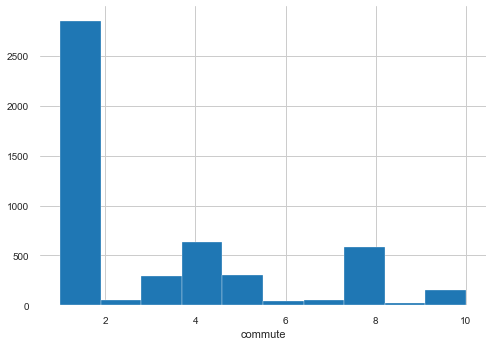

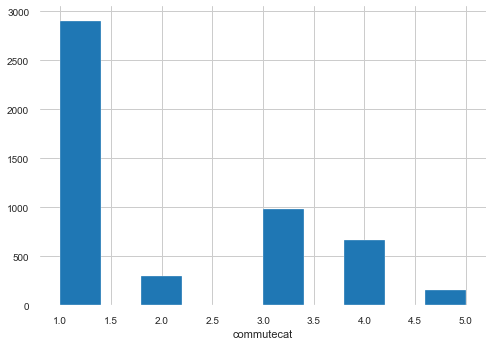

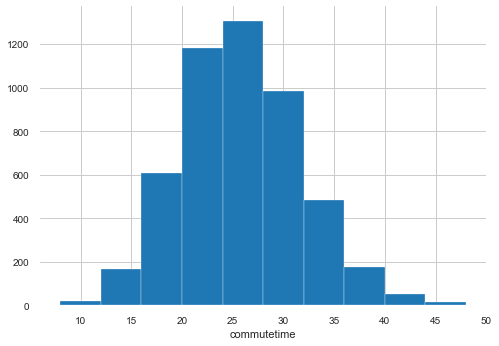

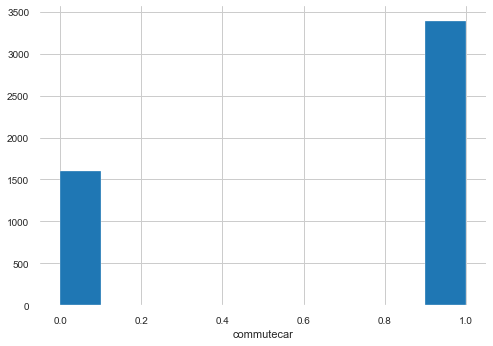

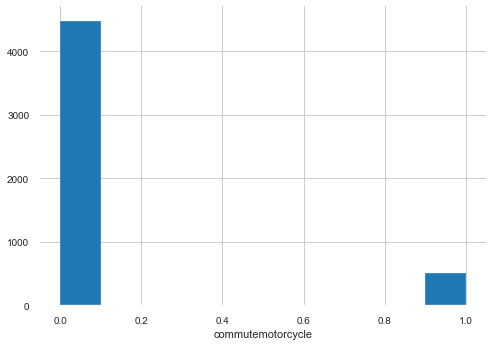

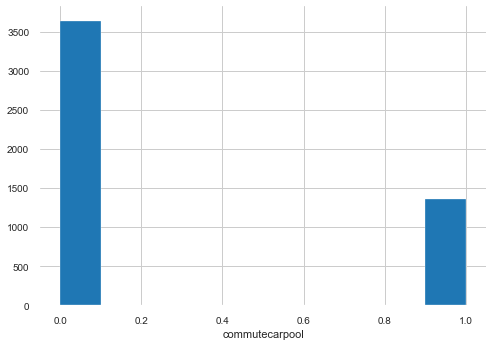

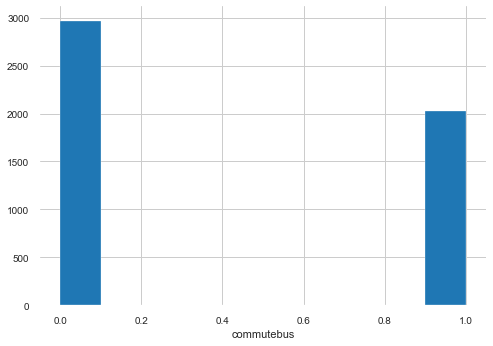

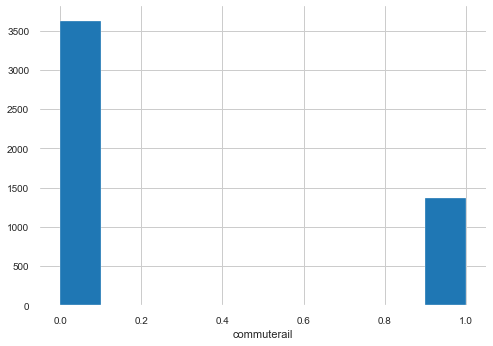

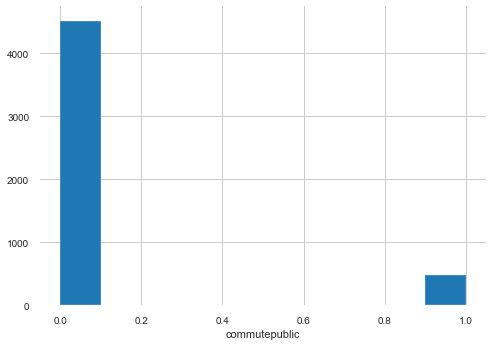

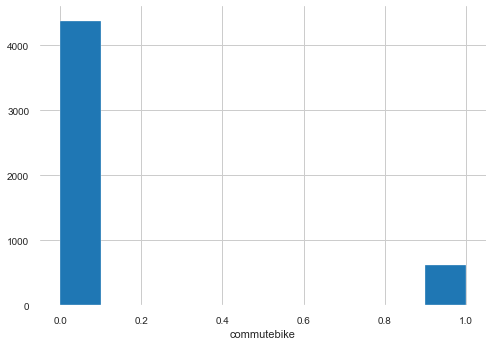

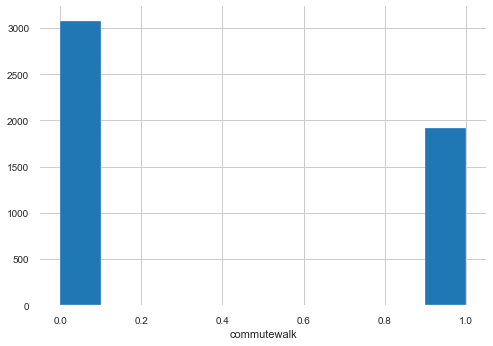

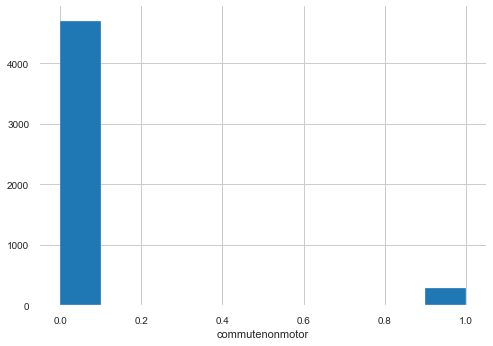

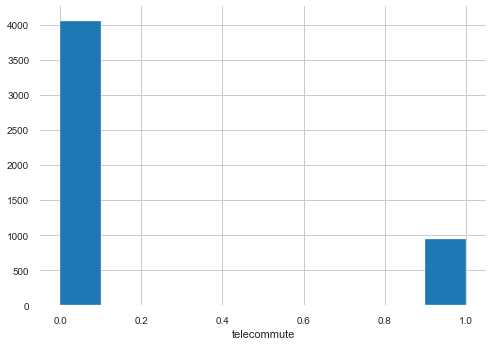

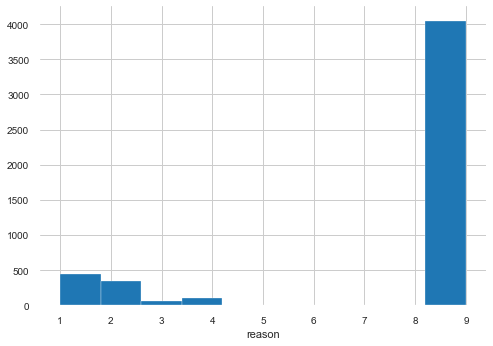

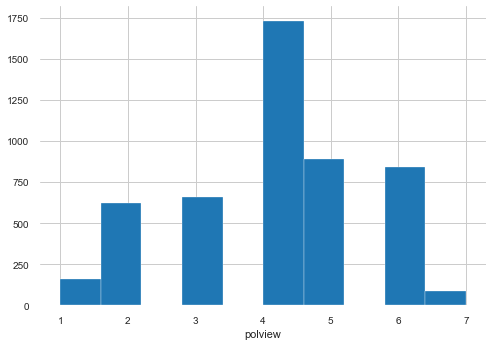

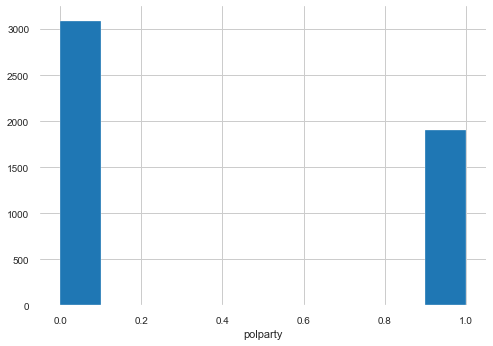

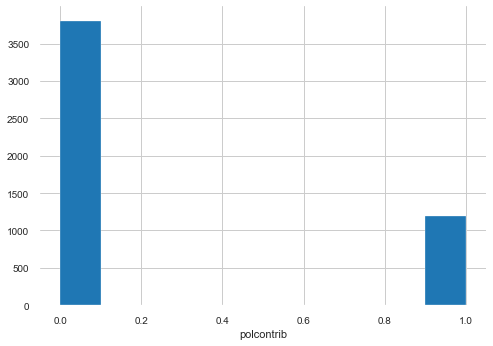

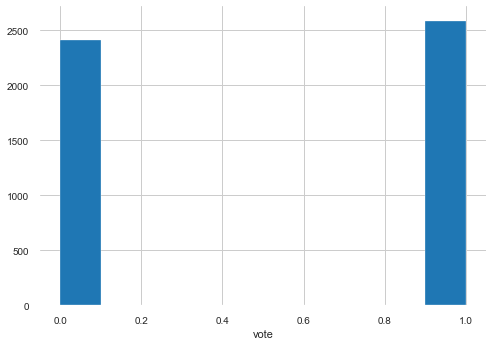

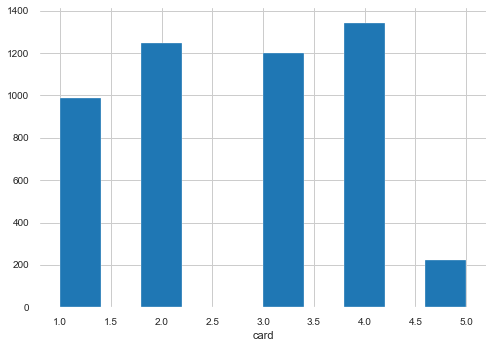

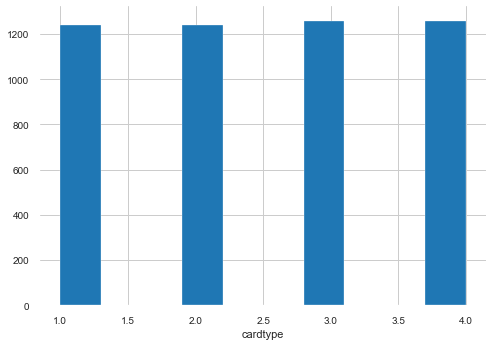

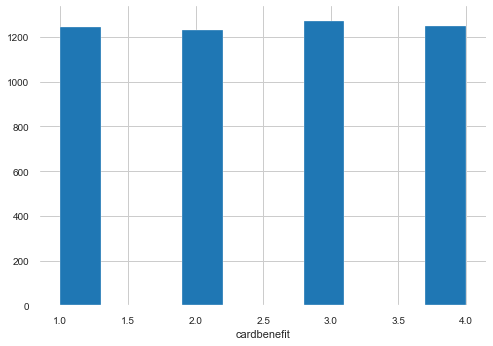

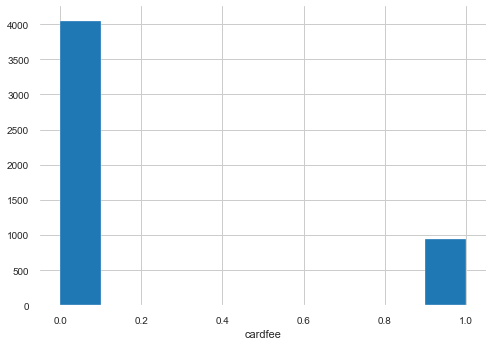

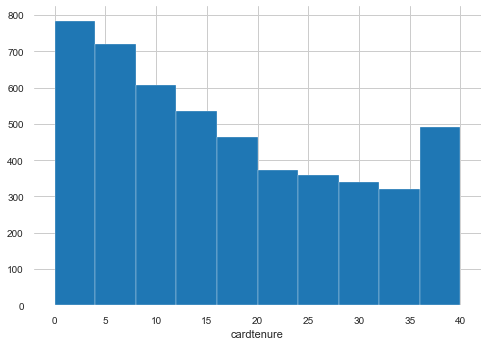

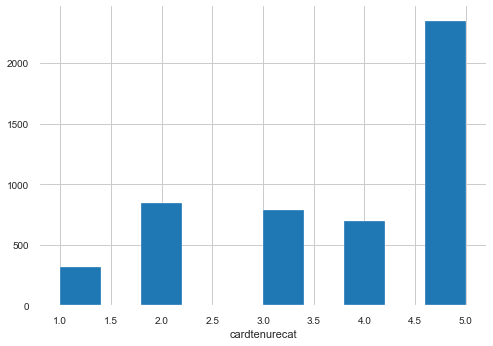

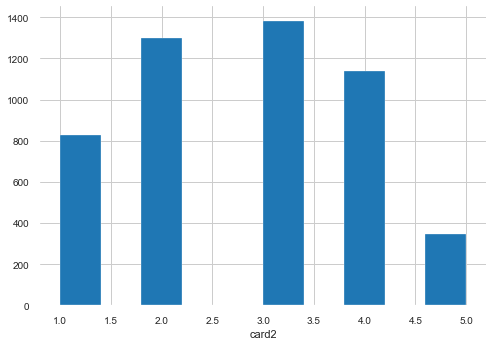

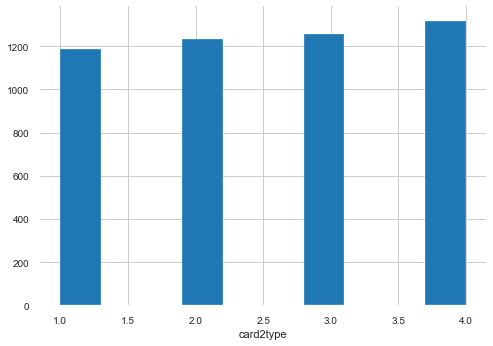

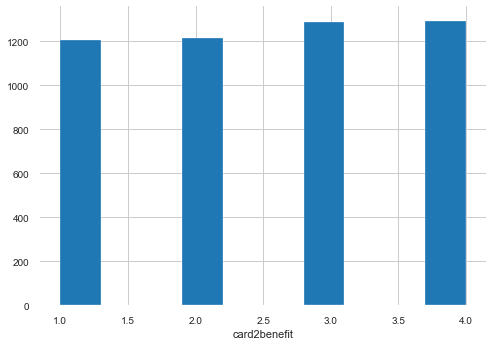

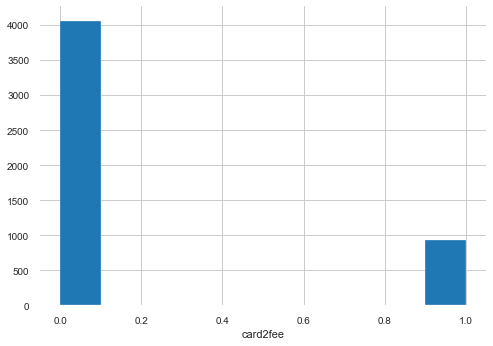

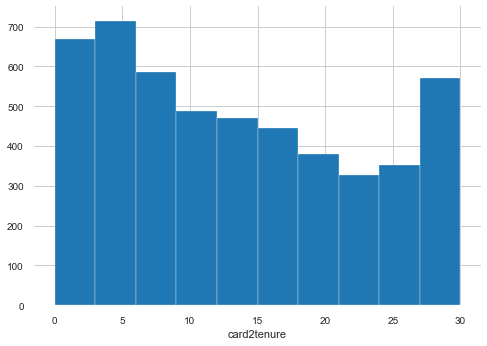

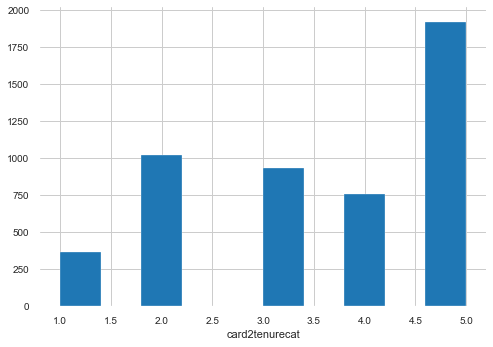

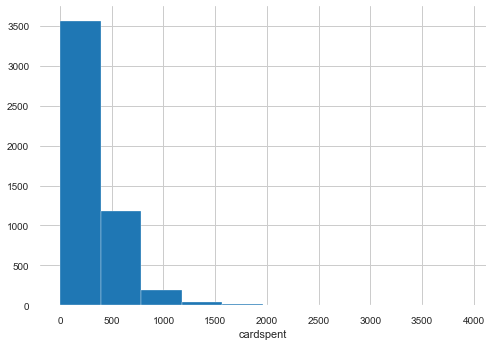

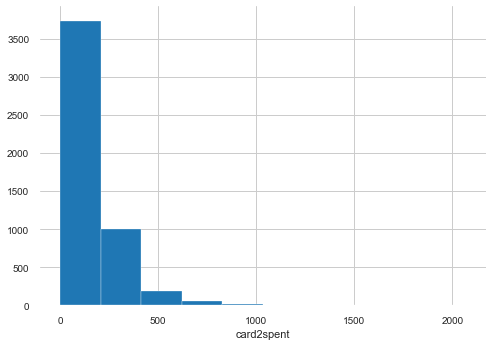

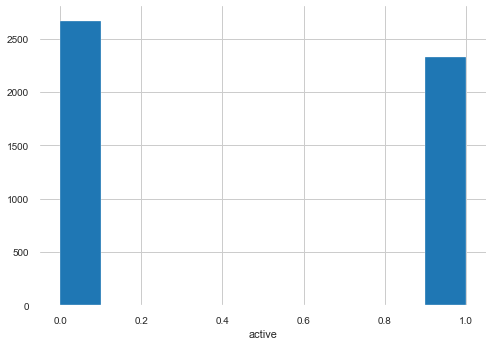

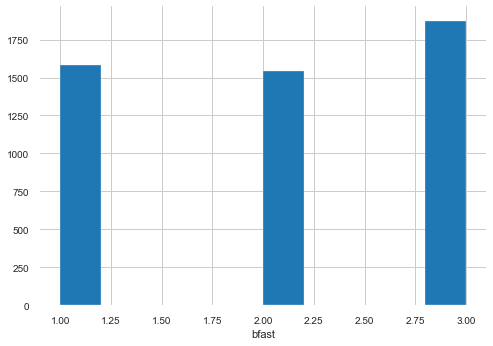

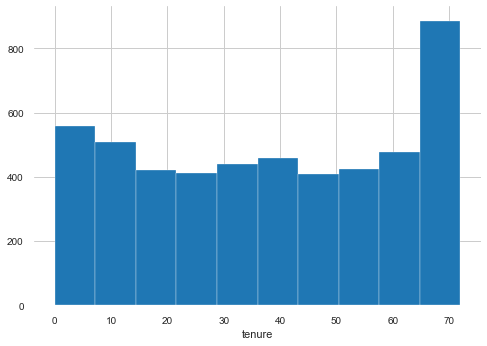

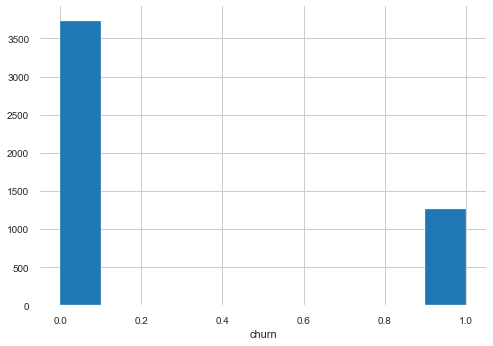

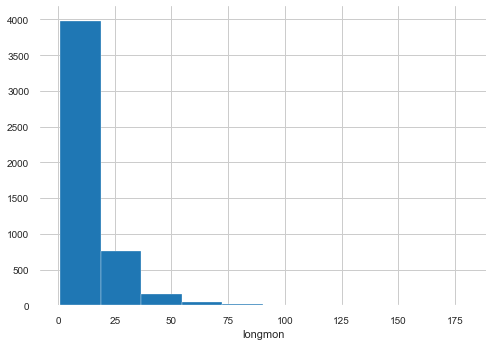

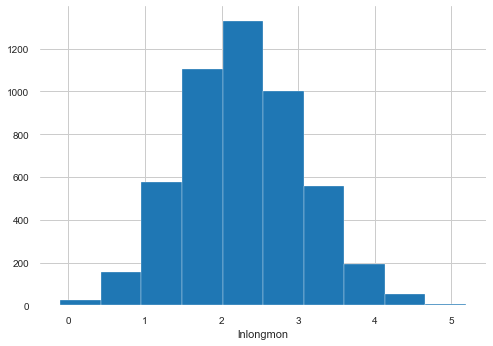

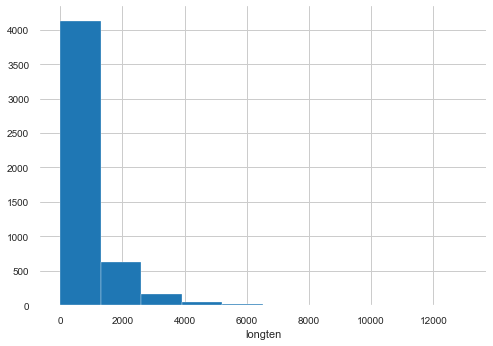

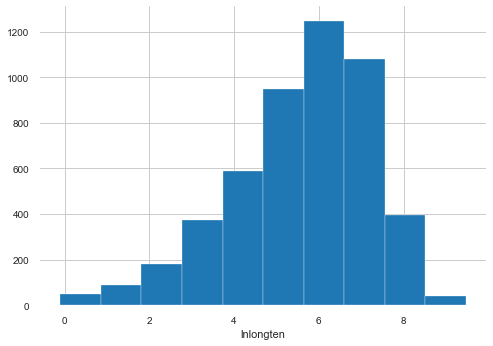

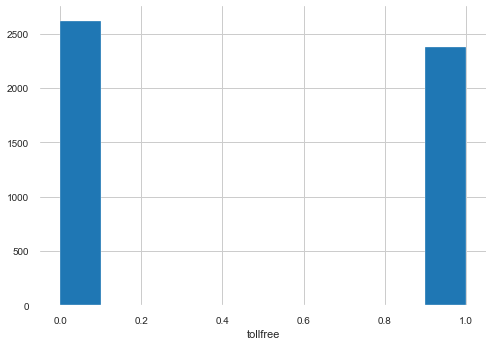

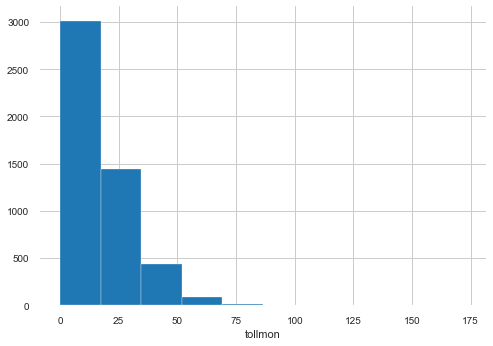

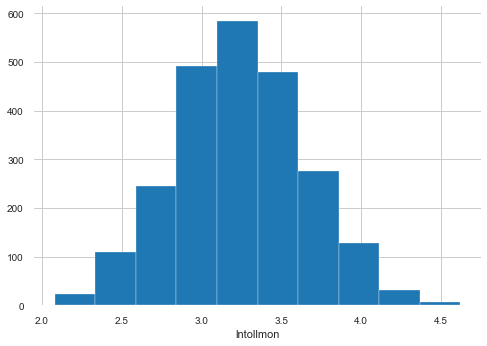

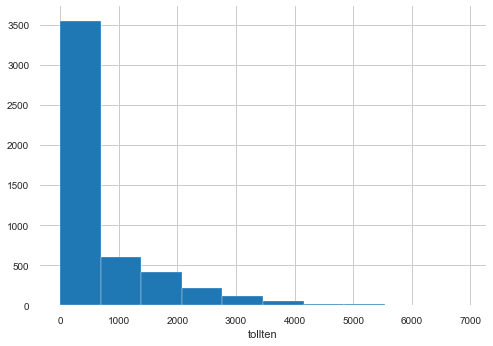

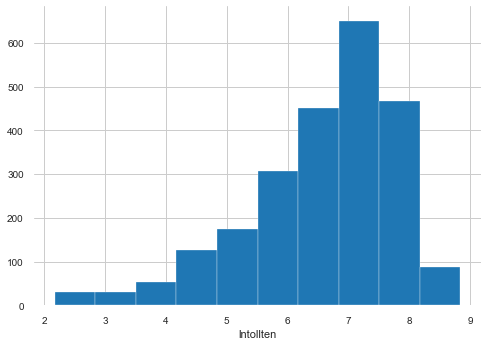

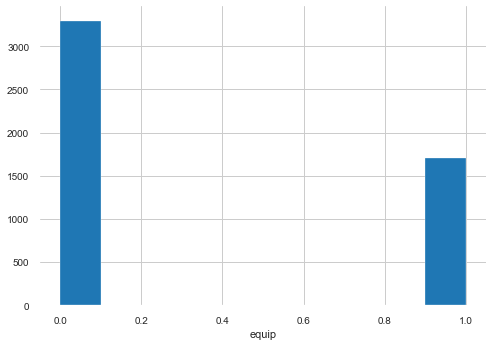

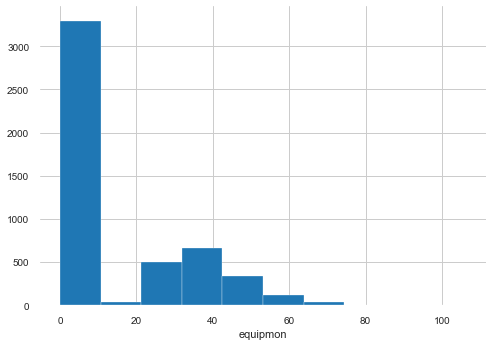

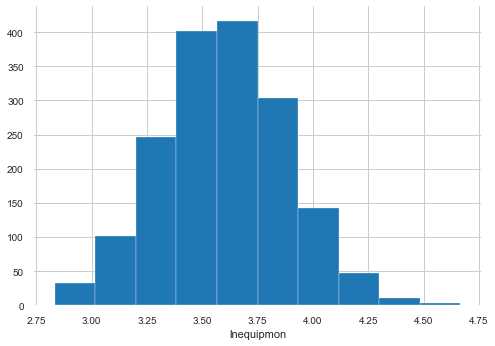

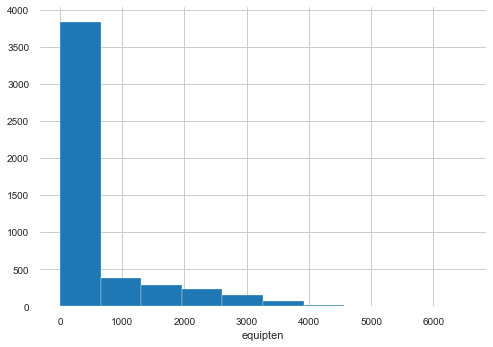

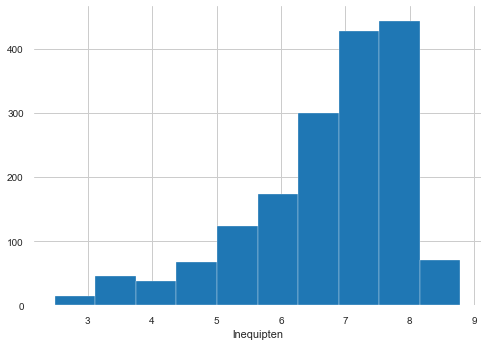

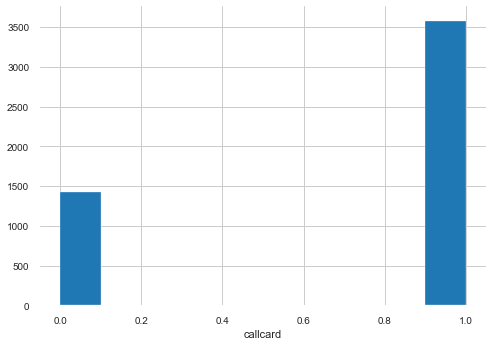

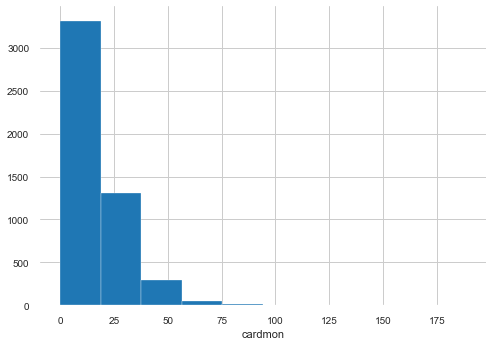

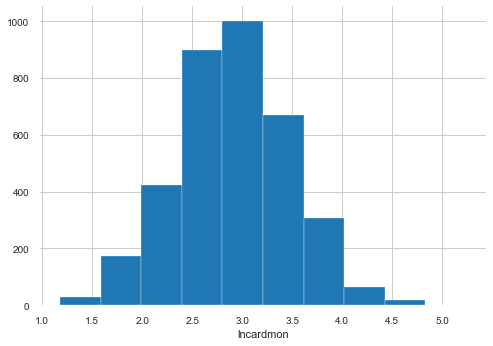

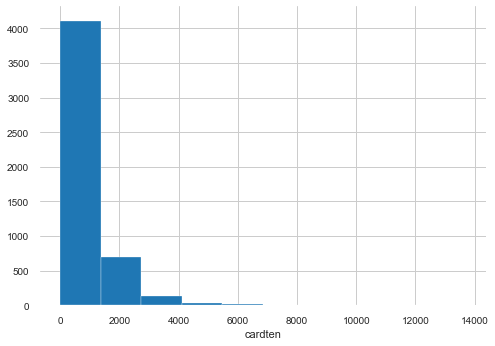

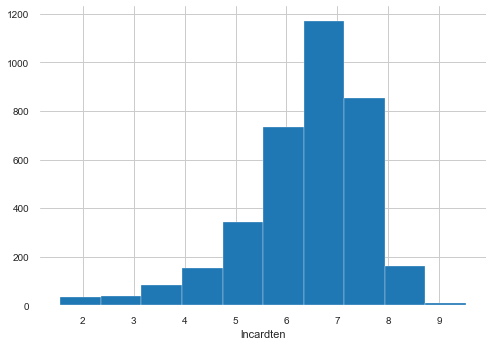

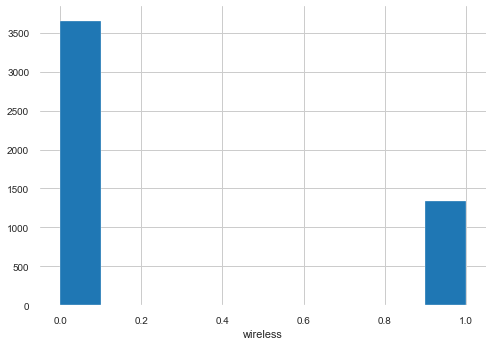

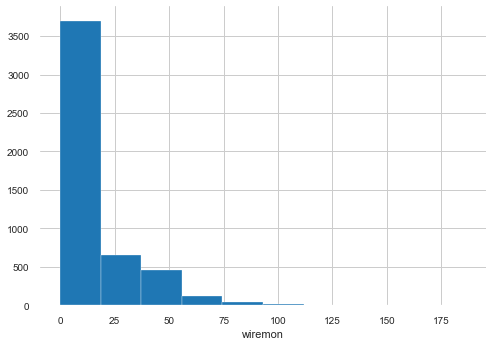

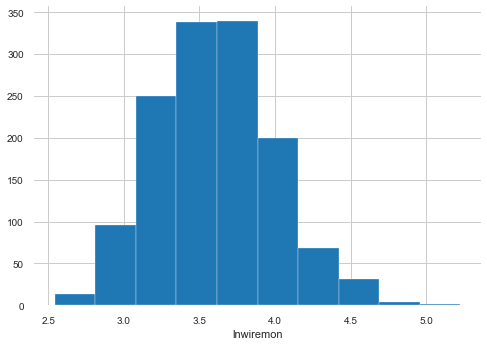

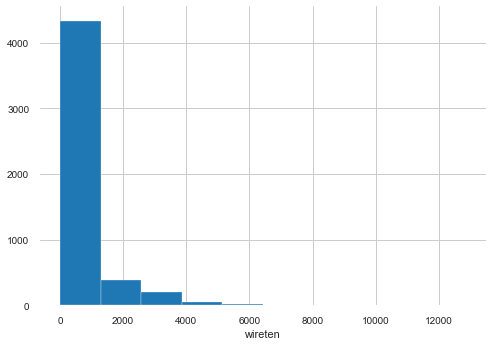

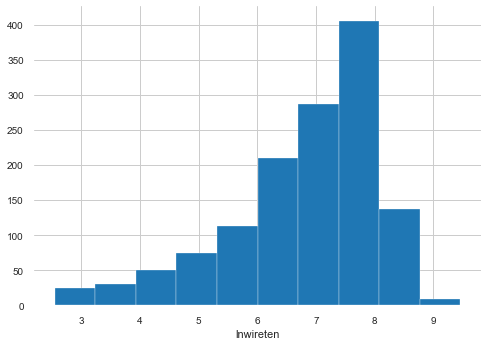

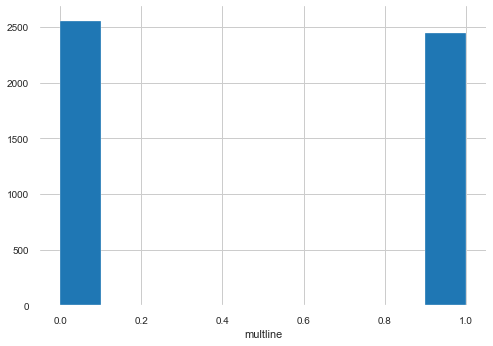

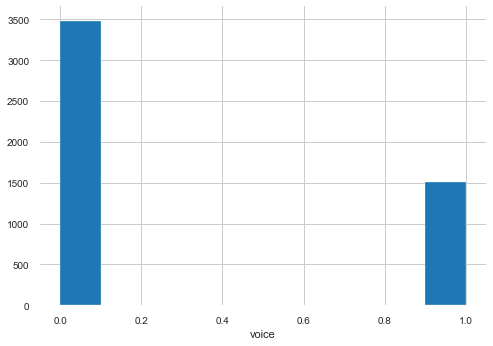

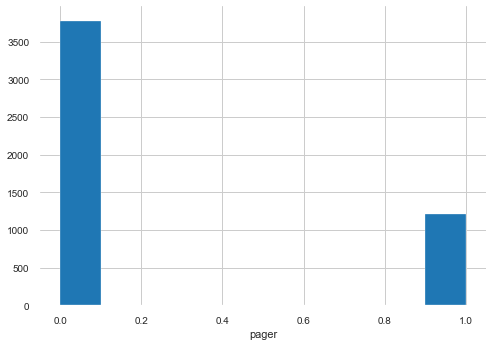

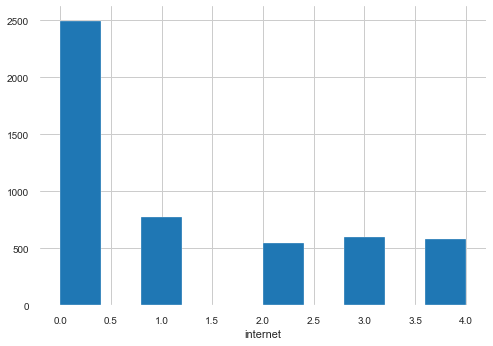

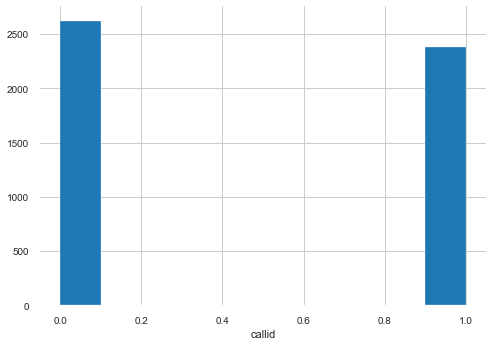

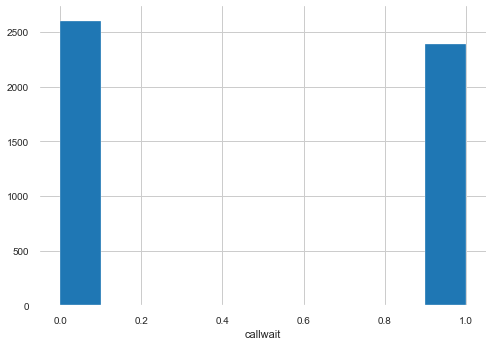

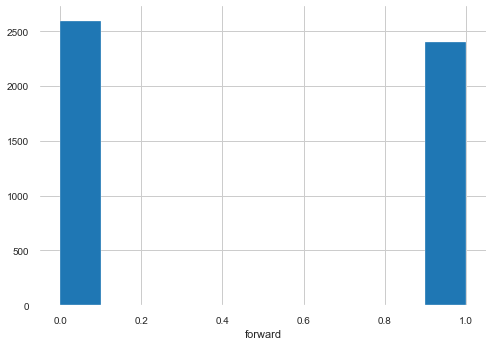

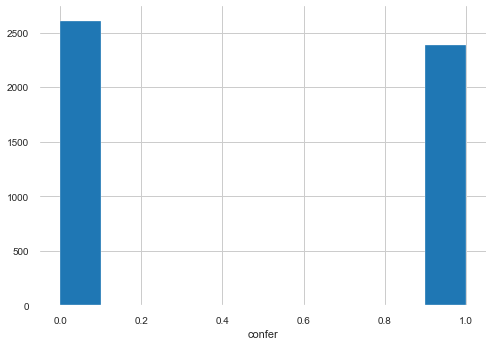

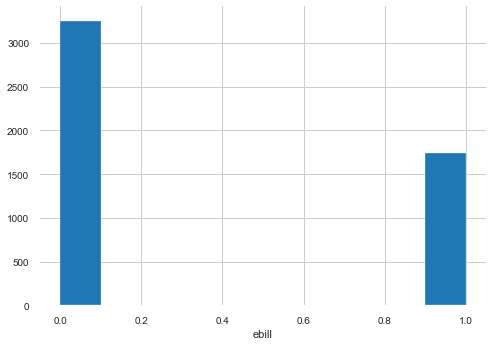

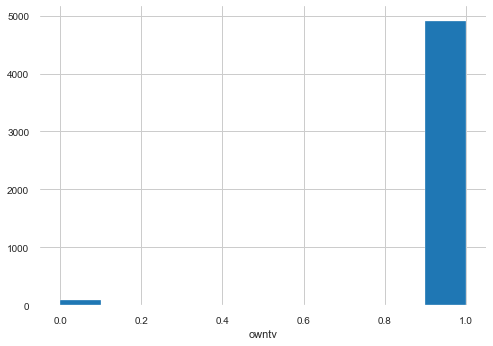

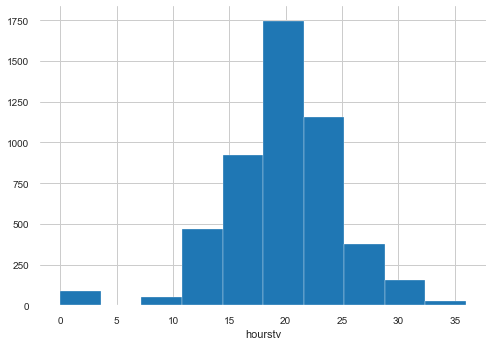

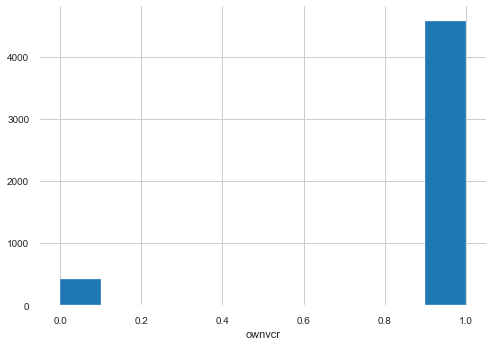

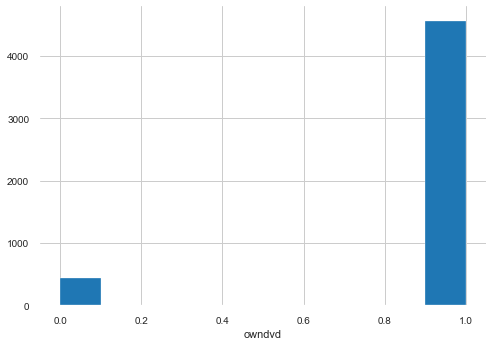

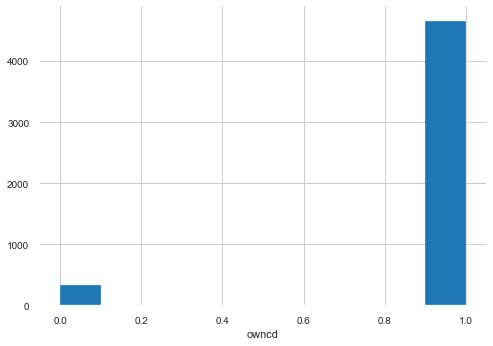

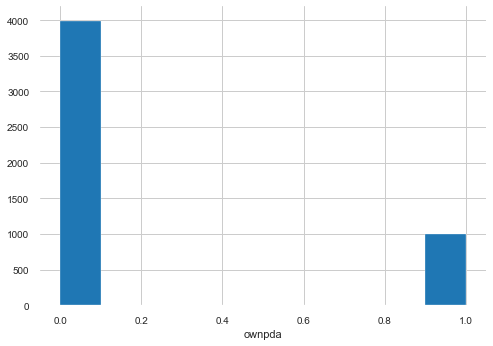

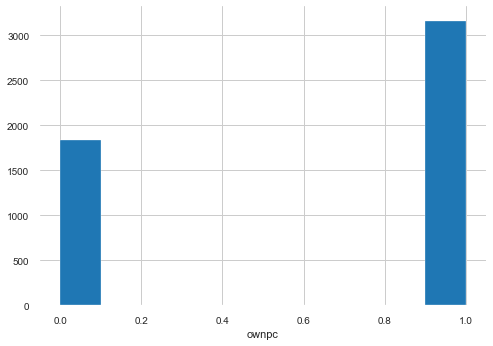

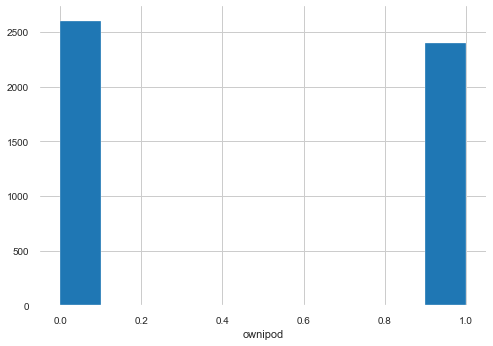

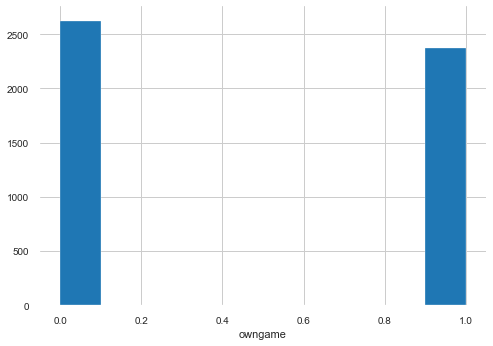

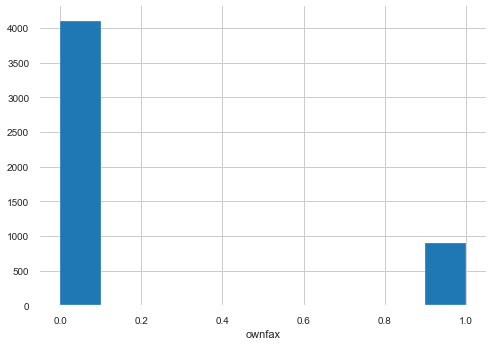

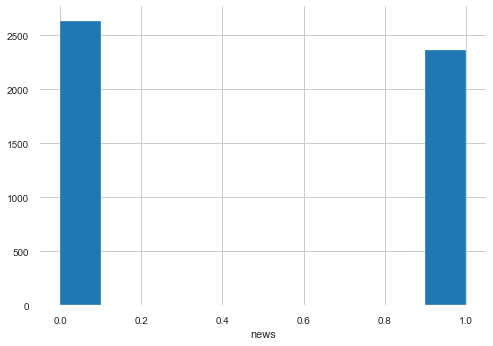

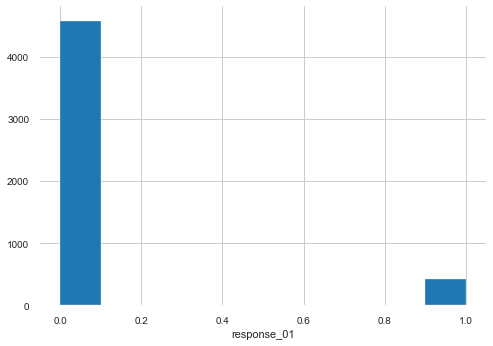

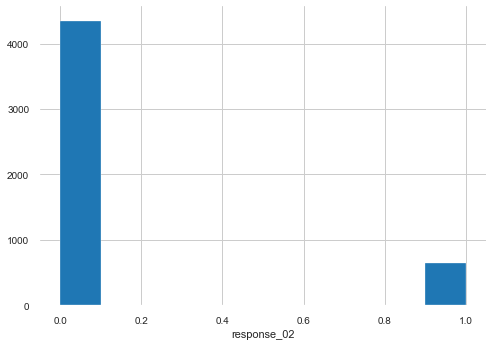

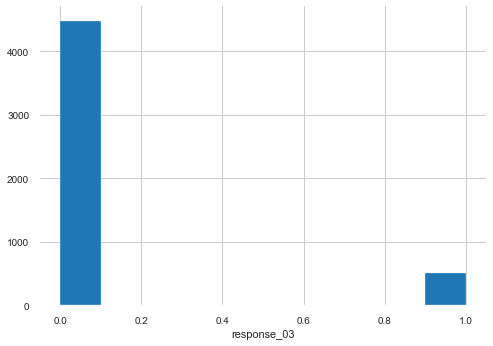

In [7]:
for i in credit_card.columns:
    credit_card[i].hist()
    plt.xlabel(str(i))
    plt.show()

In [8]:
#ProfileReport= pp.ProfileReport(credit_card)
#ProfileReport.to_file('ProfileReport.html')

In [9]:
# Insights from above plot and Pandas profiling 

# --> Transformed variables in the dataset : lninc -> we can exclude 'income' from the analysis
#                                 similarly  lncreddebt   ->  we can exclude 'creddebt' 
#                                            lnotherdebt  ->  we can exclude 'othdebt' 
#                                            lnlongmon    ->  we can exclude 'longmon'
#                                            lnlongten    ->  we can exclude 'longten'
#                                            lntollmon    ->  we can exclude 'tollmon'
#                                            lntollten    ->  we can exclude 'tollten'
#                                            lnequipmon   ->  we can exclude 'equipmon'
#                                            lnequipten   ->  we can exclude 'equipten' 
#                                            lncardmon    ->  we can exclude 'cardmon'
#                                            lncardten    ->  we can exclude 'cardten'
#                                            lnwiremon    ->  we can exclude 'wiremon'
#                                            lnwireten    ->  we can exclude 'wireten'
# -'card' and 'card2' can be dropped as these variables do not make any sense to be included
# - addresscat is highly correlated with address - we can exclude
# - agecat is highly correlated with age - we can exclude
# - card2tenure is highly correlated with cardtenure - we can exclude
# - card2tenurecat is highly correlated with card2tenure - we can exclude
# - commutecat is highly correlated with commute - we can exclude
# - edcat is highly correlated with ed - we can exclude
# - equipmon is highly correlated with equip - we can exclude
# - inccat is highly correlated with lninc - we can exclude
# - lnlongten is highly correlated with lnlongmon - we can exclude
# - longten is highly correlated with longmon - we can exclude
# - spoused is highly correlated with marital - we can exclude
# - spousedcat is highly correlated with spoused - we can exclude
# - tenure is highly correlated with card2tenure - we can exclude

#### Data Preparation

In [10]:
# Insignificant variables, so dropping these variables
credit_card.drop(columns=['custid','birthmonth'],inplace=True)

In [11]:
# Dropping the variables whose transformed variable already present in the data
credit_card.drop(['income','creddebt', 'othdebt', 'longmon', 'longten', 'tollmon', 'tollten', 'equipmon','equipten', 'cardmon','cardten', 'wiremon', 'wireten'], axis=1,inplace=True)

In [12]:
# Dropping insignificant variables on the basis of correlation and data understanding
credit_card.drop(['address', 'card2tenure', 'card', 'card2', 'cardbenefit', 'card2type', 
                  'agecat','edcat','spoused','commute','ed','equip'], axis=1,inplace=True)

In [13]:
# Checking for missings> 25%
mis=credit_card.isnull().sum()
print ("Variables with Percentage of Missing Value:")

totalx=5000.00
for var in mis.index:
    t=mis[var]/totalx
    t=t*100
    if t>= 25.00:
            print ('{0}:{1}'.format(var,t))
        


Variables with Percentage of Missing Value:
lntollmon:52.44
lntollten:52.44
lnequipmon:65.92
lnequipten:65.92
lncardmon:28.38
lncardten:28.439999999999998
lnwiremon:73.11999999999999
lnwireten:73.11999999999999


In [14]:
# Dropping variables having large number of missing values i.e. having missing values greater than 25%
credit_card.drop(['lntollmon','lntollten','lnequipmon','lnequipten','lncardmon','lncardten','lnwiremon','lnwireten'],axis=1,inplace=True)

In [15]:
credit_card.shape

(5000, 95)

In [16]:
# Defining categorical variables
for x in ['region','gender','jobcat','union','empcat','retire','inccat','default','jobsat','marital',
          'spousedcat','homeown','hometype','addresscat','cars','carown','cartype','carcatvalue','carbought',
          'carbuy','commutecat','commutecar','commutemotorcycle','commutecarpool','commutebus','commuterail',
          'commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason','polview','polparty',
          'polcontrib','vote','cardtype','cardfee','cardtenurecat','card2benefit','card2fee','card2tenurecat',
          'active','bfast','churn','tollfree','callcard','wireless','multline','voice','pager','internet','callid',
          'callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame',
          'ownfax','news','response_01','response_02','response_03']:
    credit_card[x] = credit_card[x].astype('object')

In [17]:
# Defining the dependent y variable by concatenating the spent from the two cards

credit_card['cards_spent']=credit_card.cardspent+credit_card.card2spent
credit_card.cards_spent.head()
credit_card.drop(columns=['cardspent','card2spent'],inplace=True)

In [18]:
# Separation of continuos and categorical variables
conti_vars=credit_card.select_dtypes(['float64','int64'])
cat_vars=credit_card.select_dtypes('object')

pd.set_option('display.max_columns', 500)
conti_vars.head()

,townsize,age,employ,lninc,debtinc,lncreddebt,lnothdebt,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,tenure,lnlongmon,lnlongten,hourstv,cards_spent
0,2.0,20,0,3.433987,11.1,0.183079,0.806516,3,0,0,0,0,0,0,0,0,14.3,22.0,2,5,1.871802,3.538057,13,149.46
1,5.0,22,0,2.708050,18.6,0.200505,0.449788,2,6,0,0,0,0,0,0,6,6.8,29.0,4,39,2.186051,5.800909,18,77.54
2,4.0,67,16,3.555348,9.9,-0.074056,0.930738,3,3,2,1,0,0,0,0,0,18.8,24.0,35,65,3.346389,7.527444,21,359.97
3,3.0,23,0,2.995732,5.7,-3.780995,0.110826,5,0,0,0,0,0,0,0,0,8.7,38.0,5,36,1.791759,5.295564,26,359.41
4,2.0,26,1,3.135494,1.7,-1.538705,-1.735336,4,0,0,0,0,0,0,0,0,10.6,32.0,8,21,1.115142,4.305416,27,507.83


In [19]:
pd.set_option('display.max_columns', 500)
cat_vars.head()

,region,gender,jobcat,union,empcat,retire,inccat,default,jobsat,marital,spousedcat,homeown,hometype,addresscat,cars,carown,cartype,carcatvalue,carbought,carbuy,commutecat,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,cardtype,cardfee,cardtenurecat,card2benefit,card2fee,card2tenurecat,active,bfast,churn,tollfree,callcard,wireless,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,1,1,1,1,1,0,2,1,1,0,-1,0,2,1,2,1,0,1,0,0,4,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,1,0,2,1,0,2,0,3,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0
1,5,0,2,0,1,0,1,1,1,0,-1,1,3,1,2,1,1,1,0,0,1,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,4,0,2,3,0,2,1,1,0,0,1,1,1,1,1,4,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0
2,3,1,2,0,5,0,2,0,4,1,2,1,1,5,3,1,1,1,0,1,3,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,1,0,5,3,0,5,0,3,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0
3,4,0,2,0,1,0,1,1,2,1,4,1,3,2,3,1,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,1,0,2,4,0,2,1,1,0,0,1,0,1,0,0,2,0,0,0,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0
4,2,0,2,0,1,0,1,0,1,1,2,0,2,2,1,0,1,1,0,1,3,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,2,0,3,2,0,3,1,3,0,1,1,1,0,1,0,3,1,1,1,1,0,1,1,1,1,0,1,0,1,0,0,0,1,0


#### Bivariate Analysis

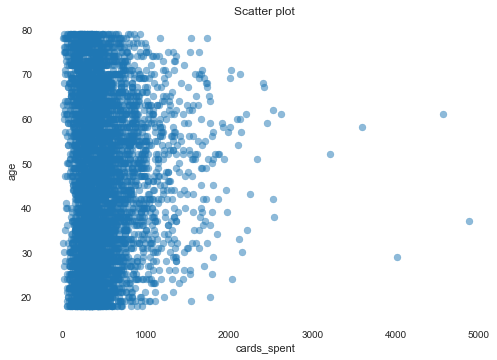

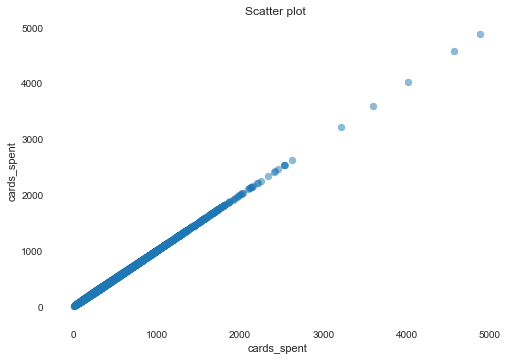

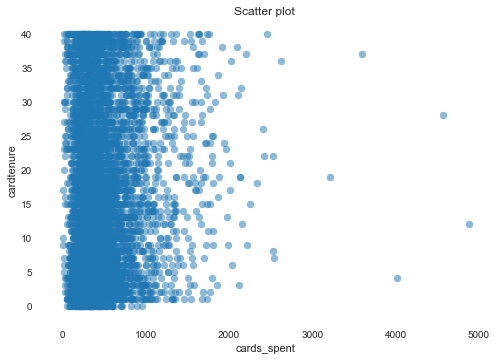

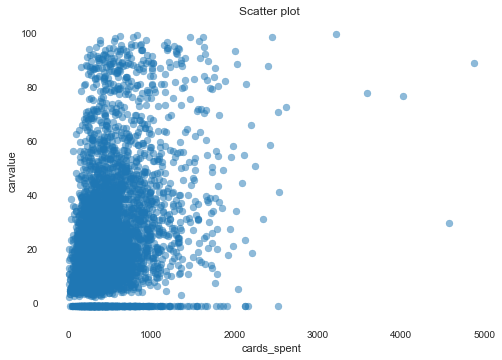

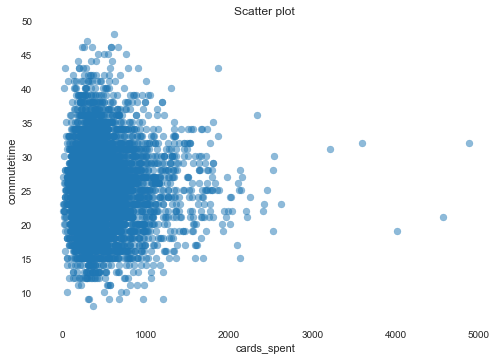

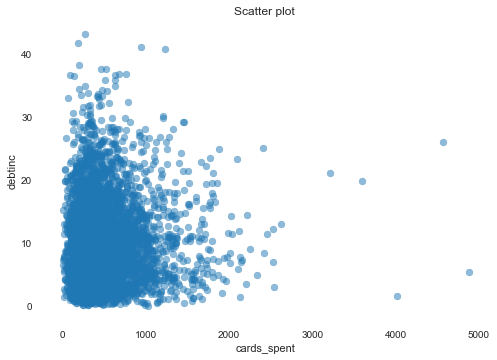

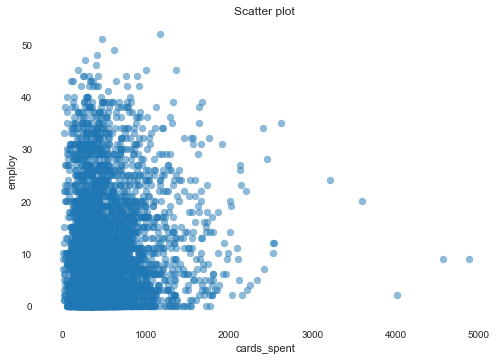

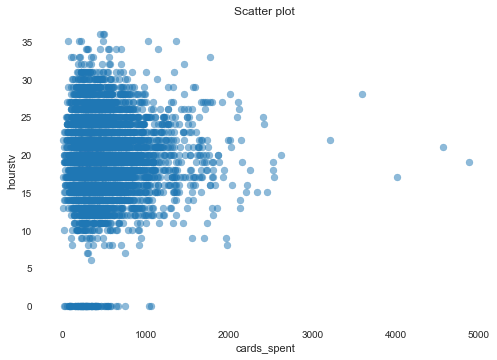

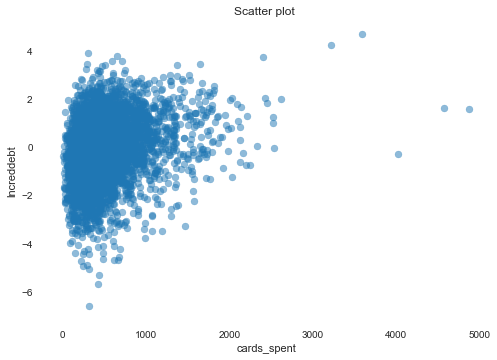

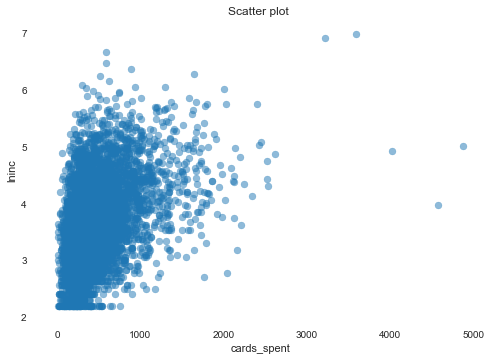

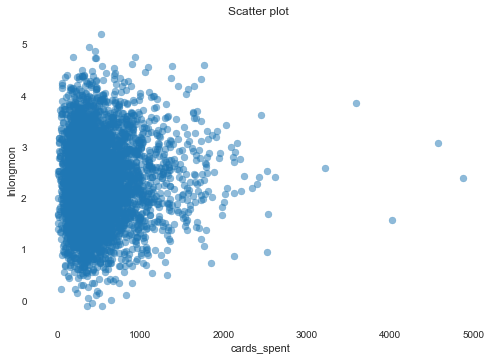

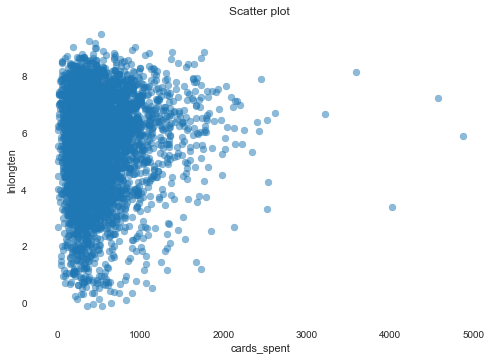

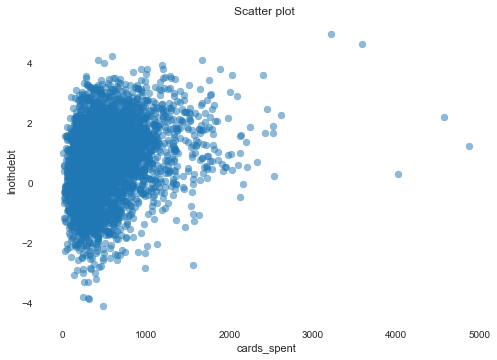

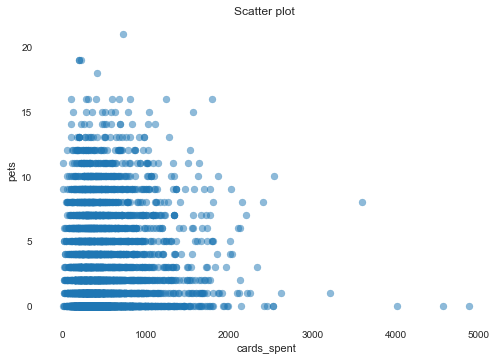

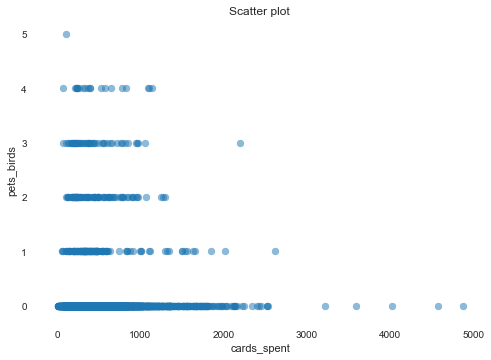

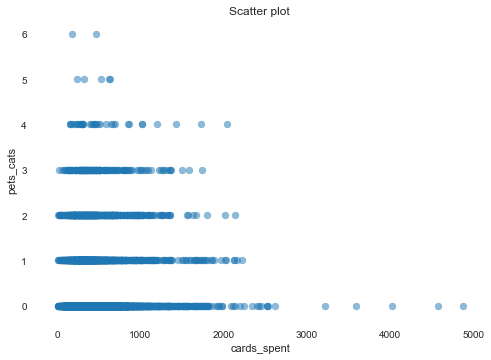

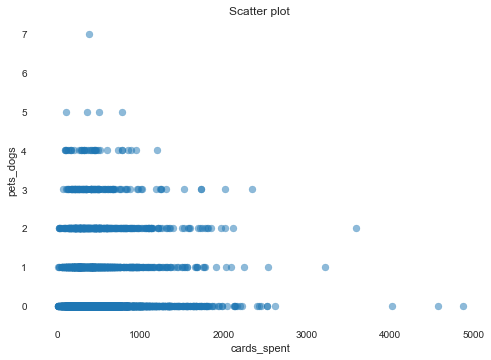

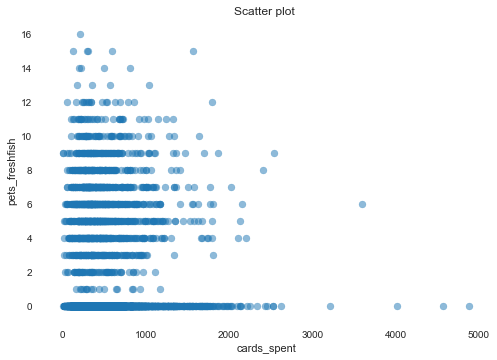

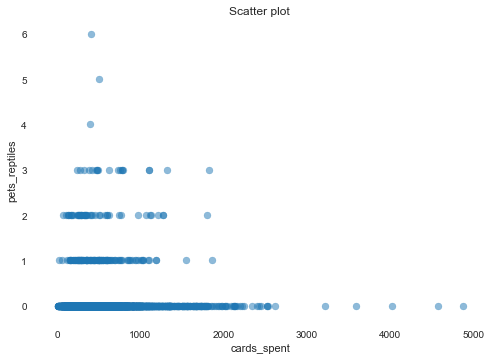

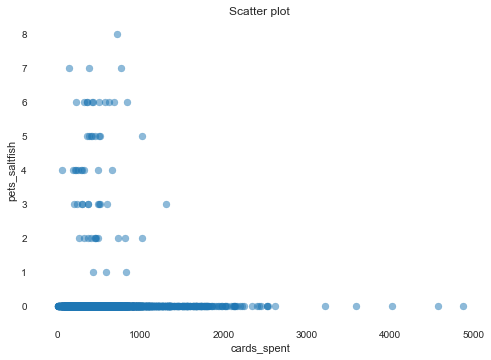

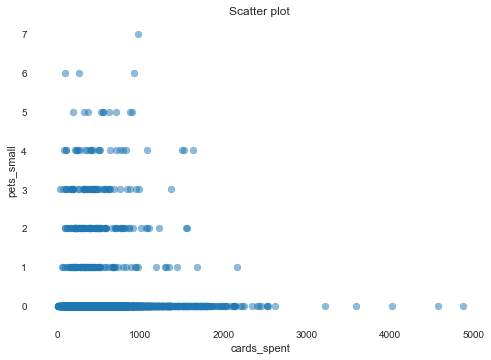

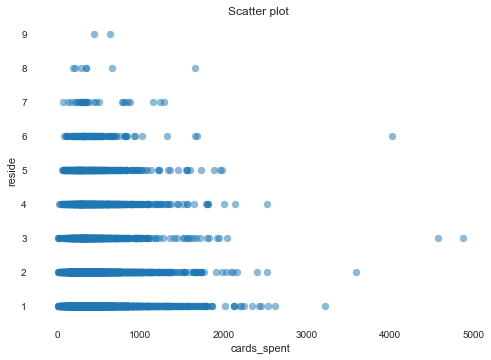

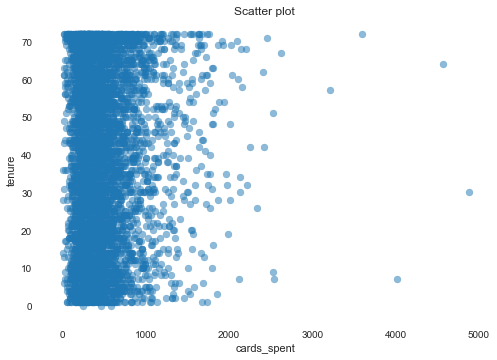

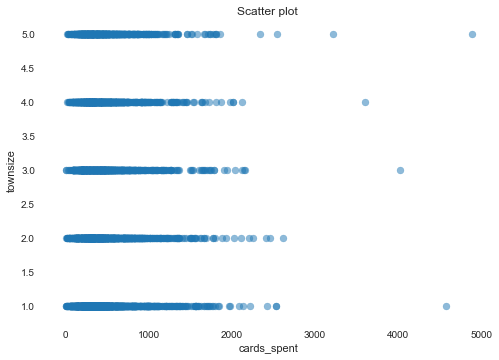

In [20]:
# Checking Bi-Variate Relationship with target variable
for i in credit_card.columns.difference(cat_vars.columns):
    plt.scatter(credit_card.cards_spent,credit_card[i], alpha=0.5)
    plt.title('Scatter plot ')
    plt.xlabel('cards_spent')
    plt.ylabel(str(i))
    plt.show()  

#### Outlier Treatment

In [21]:
# Continuous variables
conti_vars = conti_vars.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [22]:
conti_vars.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
townsize,4998.0,2.0,13431.00,2.69,3.00,1.43,2.03,1.00,1.00,1.00,1.00,1.00,3.00,4.00,5.00,5.00,5.00,5.00
age,5000.0,0.0,235128.00,47.03,47.00,17.77,315.78,18.00,18.00,20.00,23.00,31.00,47.00,62.00,72.00,76.00,79.00,79.00
employ,5000.0,0.0,48490.00,9.70,7.00,9.58,91.81,0.00,0.00,0.00,0.00,2.00,7.00,15.00,25.00,31.00,39.00,39.00
lninc,5000.0,0.0,18485.25,3.70,3.64,0.74,0.55,2.20,2.20,2.56,2.77,3.18,3.64,4.20,4.69,4.99,5.61,5.61
debtinc,5000.0,0.0,49570.60,9.91,8.80,6.24,38.96,0.70,0.70,1.90,2.80,5.10,8.80,13.60,18.60,22.20,29.20,29.20
lncreddebt,4999.0,1.0,-638.77,-0.13,-0.08,1.24,1.54,-3.40,-3.40,-2.29,-1.74,-0.95,-0.08,0.72,1.46,1.85,2.66,2.66
lnothdebt,4999.0,1.0,3491.23,0.70,0.74,1.10,1.22,-2.17,-2.17,-1.24,-0.78,-0.02,0.74,1.46,2.09,2.47,3.18,3.18
reside,5000.0,0.0,10971.00,2.19,2.00,1.36,1.85,1.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,5.00,6.00,6.00
pets,5000.0,0.0,15246.00,3.05,2.00,3.35,11.23,0.00,0.00,0.00,0.00,0.00,2.00,5.00,8.00,10.00,13.00,13.00
pets_cats,5000.0,0.0,2452.00,0.49,0.00,0.82,0.68,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,3.00,3.00


In [23]:
# Categorical variable summary
cat_vars.apply(categorical_var_summary).T.round(2)

,N,NMISS,MODE,FREQ,PERCENT
region,5000.0,0.0,5.0,1027.0,20.54
gender,5000.0,0.0,1.0,2518.0,50.36
jobcat,5000.0,0.0,2.0,1640.0,32.80
union,5000.0,0.0,0.0,4244.0,84.88
empcat,5000.0,0.0,2.0,1180.0,23.60
...,...,...,...,...,...
ownfax,5000.0,0.0,0.0,4106.0,82.12
news,5000.0,0.0,0.0,2637.0,52.74
response_01,5000.0,0.0,0.0,4582.0,91.64
response_02,5000.0,0.0,0.0,4351.0,87.02


#### Missing Value Imputations

In [24]:
# For categorical and continuous variables
conti_vars = conti_vars.apply(missing_imputation)
cat_vars = cat_vars.apply(missing_imputation)

In [25]:
#Checking Missing values
print(sum(conti_vars.isnull().sum()))
print(sum(cat_vars.isnull().sum()))

0
0


#### Dummy variable creation

In [27]:
# spousedcat contains negative value, replacing the negative value with 0
cat_vars.spousedcat=cat_vars.spousedcat.replace([-1],[0])

In [28]:
#Creating dummies for nominal categorical variables
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=False)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

for c_feature in cat_vars:
    cat_vars[c_feature] = cat_vars[c_feature].astype('category')
    cat_vars = create_dummies(cat_vars , c_feature )

In [29]:
cat_vars

,region_1,region_2,region_3,region_4,region_5,gender_0,gender_1,jobcat_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_0,union_1,empcat_1,empcat_2,empcat_3,empcat_4,empcat_5,retire_0,retire_1,inccat_1,inccat_2,inccat_3,inccat_4,inccat_5,default_0,default_1,jobsat_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_0,marital_1,spousedcat_0,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_0,homeown_1,hometype_1,hometype_2,hometype_3,hometype_4,addresscat_1,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_0,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_-1,carown_0,carown_1,cartype_-1,cartype_0,cartype_1,carcatvalue_-1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_-1,carbought_0,carbought_1,carbuy_0,carbuy_1,commutecat_1,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_0,commutecar_1,commutemotorcycle_0,commutemotorcycle_1,commutecarpool_0,commutecarpool_1,commutebus_0,commutebus_1,commuterail_0,commuterail_1,commutepublic_0,commutepublic_1,commutebike_0,commutebike_1,commutewalk_0,commutewalk_1,commutenonmotor_0,commutenonmotor_1,telecommute_0,telecommute_1,reason_1,reason_2,reason_3,reason_4,reason_9,polview_1,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_0,polparty_1,polcontrib_0,polcontrib_1,vote_0,vote_1,cardtype_1,cardtype_2,cardtype_3,cardtype_4,cardfee_0,cardfee_1,cardtenurecat_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2benefit_1,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_0,card2fee_1,card2tenurecat_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_0,active_1,bfast_1,bfast_2,bfast_3,churn_0,churn_1,tollfree_0,tollfree_1,callcard_0,callcard_1,wireless_0,wireless_1,multline_0,multline_1,voice_0,voice_1,pager_0,pager_1,internet_0,internet_1,internet_2,internet_3,internet_4,callid_0,callid_1,callwait_0,callwait_1,forward_0,forward_1,confer_0,confer_1,ebill_0,ebill_1,owntv_0,owntv_1,ownvcr_0,ownvcr_1,owndvd_0,owndvd_1,owncd_0,owncd_1,ownpda_0,ownpda_1,ownpc_0,ownpc_1,ownipod_0,ownipod_1,owngame_0,owngame_1,ownfax_0,ownfax_1,news_0,news_1,response_01_0,response_01_1,response_02_0,response_02_1,response_03_0,response_03_1
0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0
1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
2,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0
3,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,1,0
4,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,

In [30]:
# Final Dataset
credit_cards = pd.concat([conti_vars, cat_vars], axis = 1)
credit_cards.head()

,townsize,age,employ,lninc,debtinc,lncreddebt,lnothdebt,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,tenure,lnlongmon,lnlongten,hourstv,cards_spent,region_1,region_2,region_3,region_4,region_5,gender_0,gender_1,jobcat_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_0,union_1,empcat_1,empcat_2,empcat_3,empcat_4,empcat_5,retire_0,retire_1,inccat_1,inccat_2,inccat_3,inccat_4,inccat_5,default_0,default_1,jobsat_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_0,marital_1,spousedcat_0,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_0,homeown_1,hometype_1,hometype_2,hometype_3,hometype_4,addresscat_1,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_0,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_-1,carown_0,carown_1,cartype_-1,cartype_0,cartype_1,carcatvalue_-1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_-1,carbought_0,carbought_1,carbuy_0,carbuy_1,commutecat_1,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_0,commutecar_1,commutemotorcycle_0,commutemotorcycle_1,commutecarpool_0,commutecarpool_1,commutebus_0,commutebus_1,commuterail_0,commuterail_1,commutepublic_0,commutepublic_1,commutebike_0,commutebike_1,commutewalk_0,commutewalk_1,commutenonmotor_0,commutenonmotor_1,telecommute_0,telecommute_1,reason_1,reason_2,reason_3,reason_4,reason_9,polview_1,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_0,polparty_1,polcontrib_0,polcontrib_1,vote_0,vote_1,cardtype_1,cardtype_2,cardtype_3,cardtype_4,cardfee_0,cardfee_1,cardtenurecat_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2benefit_1,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_0,card2fee_1,card2tenurecat_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_0,active_1,bfast_1,bfast_2,bfast_3,churn_0,churn_1,tollfree_0,tollfree_1,callcard_0,callcard_1,wireless_0,wireless_1,multline_0,multline_1,voice_0,voice_1,pager_0,pager_1,internet_0,internet_1,internet_2,internet_3,internet_4,callid_0,callid_1,callwait_0,callwait_1,forward_0,forward_1,confer_0,confer_1,ebill_0,ebill_1,owntv_0,owntv_1,ownvcr_0,ownvcr_1,owndvd_0,owndvd_1,owncd_0,owncd_1,ownpda_0,ownpda_1,ownpc_0,ownpc_1,ownipod_0,ownipod_1,owngame_0,owngame_1,ownfax_0,ownfax_1,news_0,news_1,response_01_0,response_01_1,response_02_0,response_02_1,response_03_0,response_03_1
0,2.0,20,0,3.433987,11.1,0.183079,0.806516,3,0,0,0,0,0,0,0,0,14.3,22.0,2,5,1.871802,3.538057,13,149.46,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,1,0,0,1,1,0
1,5.0,22,0,2.708050,18.6,0.200505,0.449788,2,6,0,0,0,0,0,0,6,6.8,29.0,4,39,2.186051,5.800909,18,77.54,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,1,0
2,4.0,67,16,3.555348,9.9,-0.074056,0.930738,3,3,2,1,0,0,0,0,0,18.8,24.0,35,65,3.346389,7.527444,21,359.97,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0
3,3.0,23,0,2.995732,5.7,-3.401690,

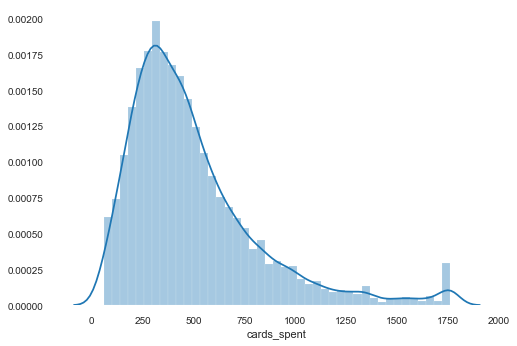

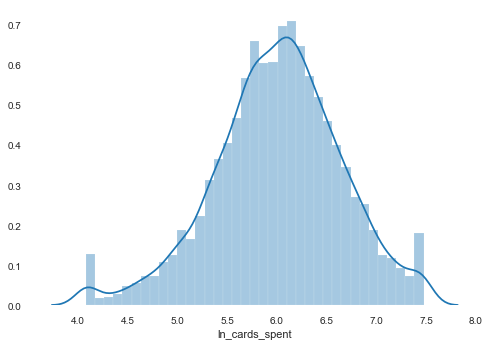

In [31]:
sns.distplot(credit_cards.cards_spent)
plt.show()
credit_cards['ln_cards_spent']=np.log(credit_cards['cards_spent']+1)
sns.distplot(credit_cards.ln_cards_spent)
plt.show()

In [32]:
# Correlation matrix
corrm = credit_cards.corr()
corrm.to_csv('corrm.csv')
corrm

,townsize,age,employ,lninc,debtinc,lncreddebt,lnothdebt,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,tenure,lnlongmon,lnlongten,hourstv,cards_spent,region_1,region_2,region_3,region_4,region_5,gender_0,gender_1,jobcat_1,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_0,union_1,empcat_1,empcat_2,empcat_3,empcat_4,empcat_5,retire_0,retire_1,inccat_1,inccat_2,inccat_3,inccat_4,inccat_5,default_0,default_1,jobsat_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_0,marital_1,spousedcat_0,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_0,homeown_1,hometype_1,hometype_2,hometype_3,hometype_4,addresscat_1,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_0,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_-1,carown_0,carown_1,cartype_-1,cartype_0,cartype_1,carcatvalue_-1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_-1,carbought_0,carbought_1,carbuy_0,carbuy_1,commutecat_1,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_0,commutecar_1,commutemotorcycle_0,commutemotorcycle_1,commutecarpool_0,commutecarpool_1,commutebus_0,commutebus_1,commuterail_0,commuterail_1,commutepublic_0,commutepublic_1,commutebike_0,commutebike_1,commutewalk_0,commutewalk_1,commutenonmotor_0,commutenonmotor_1,telecommute_0,telecommute_1,reason_1,reason_2,reason_3,reason_4,reason_9,polview_1,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_0,polparty_1,polcontrib_0,polcontrib_1,vote_0,vote_1,cardtype_1,cardtype_2,cardtype_3,cardtype_4,cardfee_0,cardfee_1,cardtenurecat_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2benefit_1,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_0,card2fee_1,card2tenurecat_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_0,active_1,bfast_1,bfast_2,bfast_3,churn_0,churn_1,tollfree_0,tollfree_1,callcard_0,callcard_1,wireless_0,wireless_1,multline_0,multline_1,voice_0,voice_1,pager_0,pager_1,internet_0,internet_1,internet_2,internet_3,internet_4,callid_0,callid_1,callwait_0,callwait_1,forward_0,forward_1,confer_0,confer_1,ebill_0,ebill_1,owntv_0,owntv_1,ownvcr_0,ownvcr_1,owndvd_0,owndvd_1,owncd_0,owncd_1,ownpda_0,ownpda_1,ownpc_0,ownpc_1,ownipod_0,ownipod_1,owngame_0,owngame_1,ownfax_0,ownfax_1,news_0,news_1,response_01_0,response_01_1,response_02_0,response_02_1,response_03_0,response_03_1,ln_cards_spent
townsize,1.000000,-0.075454,-0.059279,0.000895,-0.019571,-0.031156,-0.003003,0.044416,-0.001123,-0.018790,0.031583,-0.012798,0.009846,0.001667,0.020940,-0.007077,0.001964,0.487009,-0.042067,-0.029870,-0.015679,-0.020274,-0.002381,-0.008598,-0.290072,-0.122587,-0.014833,0.090651,0.335430,-0.009489,0.009489,-0.004367,0.020880,-0.004011,-0.004667,-0.016463,-0.002508,0.019809,-0.019809,0.033690,0.038333,-0.017855,-0.014877,-0.042661,0.065867,-0.065867,-0.018540,0.040634,-0.025765,0.008326,-0.016816,-0.023588,0.023588,0.029713,0.012630,-0.013277,-0.021015,-0.007710,-0.029919,0.029919,-0.029919,0.010537,0.018253,0.023961,-0.008741,-0.000160,-0.024066,0.024066,0.007525,-0.009985,0.002269,0.000002,0.044481,0.004438,0.012581,-0.040412,-0.011142,-0.008388,-0.001472,0.009478,0.005577,-0.022163,0.011219,0.006910,0.011201,-0.016741,-0.008388,-0.013835,0.017297,-0.008388,0.022587,-0.017599,-0.008388,0.014579,-0.012831,0.002161,-0.008388,0.008785,-0.003913,-0.009101,0.009101,-0.104228,-0.086784,0.049871,0.187573,-0.067738,0.031945,-0.031945,0.004888,-0.004888,0.016716,-0.016716,-0.131766,0.131766,-0.116960,0.116960,-0.100376,0.100376,-0.186823,0.186823,-0.260841,0.260841,-0.297547,0.297547,0.021559,-0.021559,-0.009447,0.006705,0.023558,0.006689,-0.006251,0.002350,-0.011968,-0.011992,0.020237,0.005477,-0.003887,-0.020617,0.015004,-0.015004,0.016540,-0.016540,0.005435,-0.005435,-0.007337,0.006201,0.010178,-0.009038,0.007594,-0.007594,0.007325,0.024898,0.021717,-0.015408,-0.027487,-0.011970,-0.020187,0.016002,0.015490,0.028879,-0.0288

<AxesSubplot:>

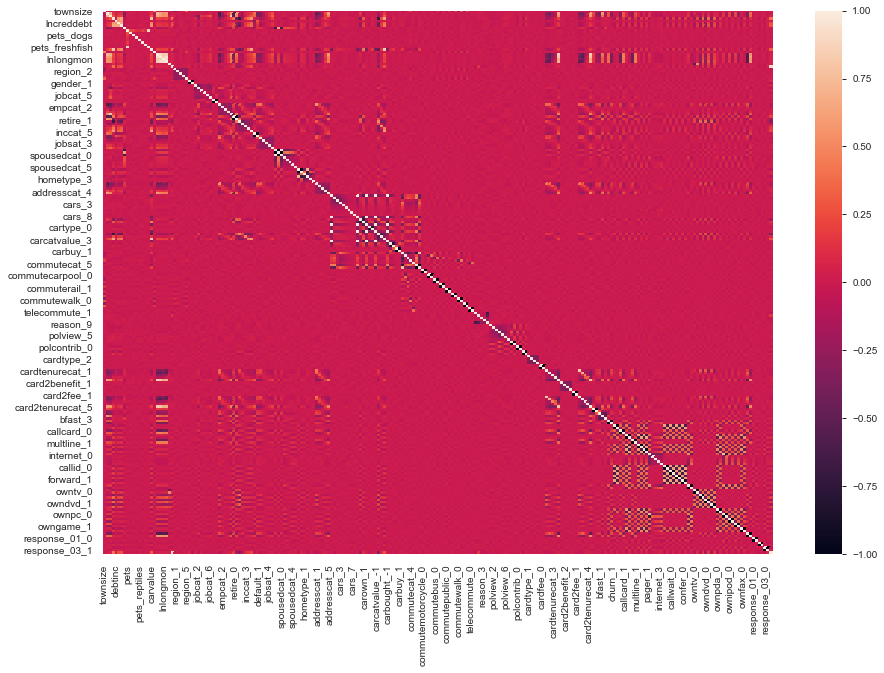

In [33]:
# Heatmap showing correlation
plt.figure(figsize = (15, 10))
sns.heatmap(credit_cards.corr())

In [34]:
# We can drop these variables on the basis of correlation with the y variable less than 0.01
credit_cards.drop(['cardfee_1','cars_6','commutecarpool_0','internet_2','bfast_1','pets_freshfish','polparty_0',
                   'pets','cars_8','active_1','commutepublic_1','jobcat_5','region_4','response_01_0','empcat_3',
                   'cardfee_0','cars_5','commutecarpool_1','age','pets_dogs','addresscat_5','townsize','commutetime',
                   'commutecat_4','polparty_1','spousedcat_2','active_0','polview_5','commutepublic_0','card2tenurecat_3',
                   'reside','carbought_1','pets_saltfish','commutewalk_0','telecommute_0','pets_cats','cars_3',
                   'jobcat_6','card2benefit_1','cardtype_2','cardtype_3','response_01_1','cardfee_1','cars_6',
                   'commutecarpool_0','internet_2','bfast_1','pets_freshfish','polparty_0','pets','cars_8','active_1',
                   'commutepublic_1','jobcat_5','pets_small','jobsat_2','commutewalk_1','region_2','telecommute_1',
                   'polview_1','region_3','cardtype_4','cardtype_1','response_01_1'], axis=1, inplace=True)


In [35]:
credit_cards

,employ,lninc,debtinc,lncreddebt,lnothdebt,pets_birds,pets_reptiles,carvalue,cardtenure,tenure,lnlongmon,lnlongten,hourstv,cards_spent,region_1,region_5,gender_0,gender_1,jobcat_1,jobcat_2,jobcat_3,jobcat_4,union_0,union_1,empcat_1,empcat_2,empcat_4,empcat_5,retire_0,retire_1,inccat_1,inccat_2,inccat_3,inccat_4,inccat_5,default_0,default_1,jobsat_1,jobsat_3,jobsat_4,jobsat_5,marital_0,marital_1,spousedcat_0,spousedcat_1,spousedcat_3,spousedcat_4,spousedcat_5,homeown_0,homeown_1,hometype_1,hometype_2,hometype_3,hometype_4,addresscat_1,addresscat_2,addresscat_3,addresscat_4,cars_0,cars_1,cars_2,cars_4,cars_7,carown_-1,carown_0,carown_1,cartype_-1,cartype_0,cartype_1,carcatvalue_-1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_-1,carbought_0,carbuy_0,carbuy_1,commutecat_1,commutecat_2,commutecat_3,commutecat_5,commutecar_0,commutecar_1,commutemotorcycle_0,commutemotorcycle_1,commutebus_0,commutebus_1,commuterail_0,commuterail_1,commutebike_0,commutebike_1,commutenonmotor_0,commutenonmotor_1,reason_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_6,polview_7,polcontrib_0,polcontrib_1,vote_0,vote_1,cardtenurecat_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_0,card2fee_1,card2tenurecat_1,card2tenurecat_2,card2tenurecat_4,card2tenurecat_5,bfast_2,bfast_3,churn_0,churn_1,tollfree_0,tollfree_1,callcard_0,callcard_1,wireless_0,wireless_1,multline_0,multline_1,voice_0,voice_1,pager_0,pager_1,internet_0,internet_1,internet_3,internet_4,callid_0,callid_1,callwait_0,callwait_1,forward_0,forward_1,confer_0,confer_1,ebill_0,ebill_1,owntv_0,owntv_1,ownvcr_0,ownvcr_1,owndvd_0,owndvd_1,owncd_0,owncd_1,ownpda_0,ownpda_1,ownpc_0,ownpc_1,ownipod_0,ownipod_1,owngame_0,owngame_1,ownfax_0,ownfax_1,news_0,news_1,response_02_0,response_02_1,response_03_0,response_03_1,ln_cards_spent
0,0,3.433987,11.1,0.183079,0.806516,0,0,14.300,2,5,1.871802,3.538057,13,149.46,1,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,5.013697
1,0,2.708050,18.6,0.200505,0.449788,0,0,6.800,4,39,2.186051,5.800909,18,77.54,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0,4.363608
2,16,3.555348,9.9,-0.074056,0.930738,0,0,18.800,35,65,3.346389,7.527444,21,359.97,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,5.888795
3,0,2.995732,5.7,-3.401690,0.110826,0,0,8.700,5,36,1.791759,5.295564,26,359.41,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,0,0,1,1,0,1,0,5.887242
4,1,3.135494,1.7,-1.538705,-1.735336,0,0,10.600,8,21,1.115142,4.305416,27,507.83,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,1,0,6.232114
...,...,...,...,...,...,...,...,...,...,...,...,...,

### Model Building

### Linear Regression

In [36]:
# we can exclude cards_spent as we can include ln_cards_spent as part of the analysis
credit_cards.drop(['cards_spent'],axis=1,inplace=True)

In [37]:
#Selecting features
features = credit_cards[credit_cards.columns.difference( ['ln_cards_spent'] )]
target = credit_cards['ln_cards_spent']

#### Variable reduction

##### RFE

In [38]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#lm = LinearRegression()
lm = RandomForestRegressor()
#create the RFE model and select 50 attributes
rfe = RFE(lm, n_features_to_select=50)
rfe = rfe.fit(features, target)

In [39]:
#Alternative of capturing the important variables
RFE_features=features.columns[rfe.get_support()]
features1 = features[RFE_features]

#### F-Regression

In [40]:
# Feature Selection based on importance
from sklearn.feature_selection import f_regression
F_values, p_values  = f_regression(features1, target )

In [41]:
import itertools
f_reg_results = [(i, v, z) for i, v, z in itertools.zip_longest(features1.columns, F_values,  ['%.3f' % p for p in p_values])]
f_reg_results=pd.DataFrame(f_reg_results, columns=['Variable','F_Value', 'P_Value'])
f_reg_results = f_reg_results.sort_values(by=['P_Value']).head(40)

In [42]:
f_reg_results

,Variable,F_Value,P_Value
0,addresscat_4,15.238725,0.000
47,tollfree_0,14.800544,0.000
46,tenure,14.224852,0.000
41,reason_2,113.477142,0.000
33,lnothdebt,405.664749,0.000
32,lnlongten,17.096178,0.000
30,lninc,980.571501,0.000
29,lncreddebt,341.663768,0.000
26,jobcat_1,15.598590,0.000
22,gender_0,31.088528,0.000


In [43]:
f_reg_results.to_csv('f_reg_results.csv')

In [44]:
Final_list = [
'addresscat_4',
#'tenure',
'reason_2',
'lnothdebt',
#'lnlongten',
'lninc',
'lncreddebt',
'jobcat_1',
#'homeown_1',
'gender_0',
#'forward_0',
'employ',
'carvalue',
#'vote_0',
#'cardtenure',
#'callwait_1',
#'callid_0',
#'voice_0',
#'ownpc_1',
#'hourstv',
#'lnlongmon',
'hometype_1',
#'bfast_3',
#'owngame_0',
#'ownipod_0',
#'cars_1',
#'polview_6',
#'region_1',
#'ebill_1',
#'jobsat_4',
'card2benefit_3',
#'news_0',
'region_5'


]

X=features[Final_list]

In [45]:
# Variance Inflation factor
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [46]:
vif.sort_values(by='VIF_Factor', ascending=False)

,VIF_Factor,features
3,8.888511,lninc
8,4.139451,carvalue
2,3.051333,lnothdebt
7,2.276568,employ
6,1.954926,gender_0
9,1.869917,hometype_1
4,1.827995,lncreddebt
5,1.427496,jobcat_1
0,1.359371,addresscat_4
10,1.339400,card2benefit_3


In [47]:
data_final = pd.concat([X,target],axis=1)

In [48]:
#Split the data into train & test
train, test = train_test_split(data_final, test_size=0.3, random_state=123)

In [49]:
train.shape

(3500, 13)

In [50]:
test.shape

(1500, 13)

In [51]:
'ln_cards_spent ~'+ '+'.join(X.columns)

'ln_cards_spent ~addresscat_4+reason_2+lnothdebt+lninc+lncreddebt+jobcat_1+gender_0+employ+carvalue+hometype_1+card2benefit_3+region_5'

In [52]:
eqn = 'ln_cards_spent ~addresscat_4+reason_2+lnothdebt+lninc+lncreddebt+jobcat_1+gender_0+employ+carvalue+hometype_1+card2benefit_3+region_5'

In [53]:
ols_model = smp.ols(formula = eqn, data=train)
ols_model_output = ols_model.fit()

In [54]:
print(ols_model_output.summary())

                            OLS Regression Results                            
Dep. Variable:         ln_cards_spent   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     75.41
Date:                Sat, 01 May 2021   Prob (F-statistic):          1.01e-164
Time:                        01:23:51   Log-Likelihood:                -3076.1
No. Observations:                3500   AIC:                             6178.
Df Residuals:                    3487   BIC:                             6258.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.5592      0.084     54.

In [55]:
train_predicted = np.exp(ols_model_output.predict(train))
test_predicted = np.exp(ols_model_output.predict(test))

In [56]:
#Metrics (MAPE, RMSE, MSE, RMSPE)
train_actual = np.exp(train.ln_cards_spent)
test_actual = np.exp(test.ln_cards_spent)

In [57]:
train_RMSE = np.sqrt(np.mean(np.square(train_actual-train_predicted)))
test_RMSE  = np.sqrt(np.mean(np.square(test_actual-test_predicted)))
print('train_RMSE:',train_RMSE)
print('test_RMSE:', test_RMSE)

train_RMSE: 299.741573633337
test_RMSE: 298.78288935200436


In [58]:
train_MAPE = np.mean(np.abs(train_actual-train_predicted)/train_actual)
test_MAPE  = np.mean(np.abs(test_actual-test_predicted)/test_actual)
print('train_MAPE:', train_MAPE)
print('test_MAPE:', test_MAPE)

train_MAPE: 0.5384483866975123
test_MAPE: 0.4919769384009402


In [59]:
np.corrcoef(train_actual, train_predicted)

array([[1.        , 0.45476721],
       [0.45476721, 1.        ]])

In [60]:
np.corrcoef(test_actual, test_predicted)

array([[1.        , 0.39321834],
       [0.39321834, 1.        ]])

In [61]:
#Check
#Errors following normal distribution
#Errors should not have relationship with Y

train_errors = train_actual-train_predicted
test_errors = test_actual-test_predicted

<AxesSubplot:>

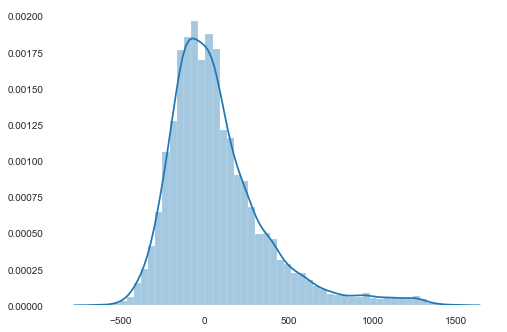

In [62]:
sns.distplot(train_errors)

In [63]:
#Decile analysis
train_results = pd.concat([train_actual, train_predicted], axis=1)
test_results = pd.concat([test_actual, test_predicted], axis=1)
train_results.columns = ['actual', 'pred']
test_results.columns = ['actual', 'pred']

In [64]:
train_results['Deciles']=pd.qcut(train_results['pred'],10, labels=False)
train_results.groupby(['Deciles']).apply(np.mean)[['actual','pred']]

,actual,pred
Deciles,,
0,290.796549,243.907759
1,354.815094,296.005460
2,396.748843,326.748708
3,417.783623,354.988679
4,450.123507,382.043725
5,460.061965,413.271490
6,505.541721,450.189081
7,590.059470,490.248803
8,658.097312,547.617865


In [65]:
test_results['Deciles']=pd.qcut(test_results['pred'],10, labels=False)
test_results.groupby(['Deciles']).apply(np.mean)[['actual','pred']]

,actual,pred
Deciles,,
0,342.034003,248.502996
1,357.038685,300.312908
2,391.363517,330.769777
3,464.945533,359.267450
4,451.672467,386.390432
5,480.651733,417.799317
6,587.620232,455.464887
7,582.849915,495.511398
8,599.235232,561.872520


### Machine Learning

In [66]:
#Independent columns
Ind_col = credit_cards.columns.difference(['ln_cards_spent'])

In [67]:
#Considering Significant Variables for Machine Learning algorithms
train_x, test_x, train_y, test_y = train_test_split(credit_cards[Ind_col],credit_cards.ln_cards_spent, test_size=0.3, random_state=6)

### Decision Trees:

In [68]:
#Importing packages
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV

In [69]:
#Model building
param_grid = {'max_depth': np.arange(2, 5),
             'max_features': np.arange(4,7)}
data_tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 3)
data_tree.fit(train_x,train_y)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([2, 3, 4]),
                         'max_features': array([4, 5, 6])})

In [70]:
data_tree.best_params_

{'max_depth': 3, 'max_features': 6}

In [71]:
#Predicting values for both training and testing data sets
tree_train_pred= data_tree.predict(train_x)
tree_test_pred=data_tree.predict(test_x)

In [72]:
#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y -tree_train_pred)/train_y)
print(MAPE_train)
MAPE_test = np.mean(np.abs(test_y- tree_test_pred)/test_y)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mse(train_y,tree_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mse(test_y,tree_test_pred))
print(RMSE_test)

MAPE values for training and testing data :
0.08544065973502948
0.08267972741347028

RMSE values for training and testing data :
0.6322293300682522
0.6139371361170705


### XGBoost

In [73]:
#Importing Required packages
import xgboost 

In [74]:
pargrid_xg = {'n_estimators': [60,70,80,100,120],
               'max_depth':[2,3,4,5]}
gscv_xg = GridSearchCV(estimator=xgboost.XGBRegressor(), 
                        param_grid=pargrid_xg, 
                        cv=3,n_jobs=-1)

data_xg=gscv_xg.fit(train_x, train_y)

In [75]:
gscv_xg.best_params_

{'max_depth': 2, 'n_estimators': 60}

In [76]:
#Predicting values for both training and testing data sets
xg_train_pred=data_xg.predict(train_x)
xg_test_pred=data_xg.predict(test_x)

In [77]:
#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y - xg_train_pred)/train_y)
print(MAPE_train)
MAPE_test = np.mean(np.abs(test_y- xg_test_pred)/test_y)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mse(train_y,xg_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mse(test_y,xg_test_pred))
print(RMSE_test)

MAPE values for training and testing data :
0.07466008902985101
0.07627159024642874

RMSE values for training and testing data :
0.5514098079729238
0.5613282232236267


In [78]:
#Identifying Key variables and Printing top 10 variables.
xg =xgboost.XGBRegressor(random_state=1234)
xg = xg.fit(train_x,train_y)
feature_importances_XG = pd.DataFrame(xg.feature_importances_,
                                   index =train_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
XG = pd.DataFrame(feature_importances_XG)
XG =XG.head(15)
lis_xg= XG.index
lis_xg

Index(['lninc', 'reason_3', 'reason_2', 'ownvcr_0', 'card2tenurecat_1',
       'reason_4', 'pets_birds', 'commutecat_5', 'region_5', 'spousedcat_4',
       'commutebike_0', 'pager_0', 'jobcat_4', 'retire_0', 'polview_2'],
      dtype='object')

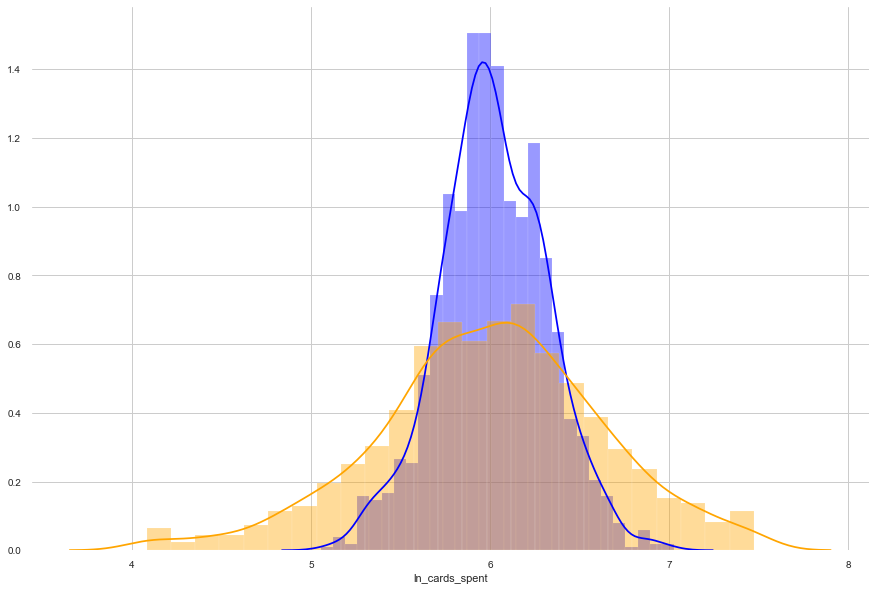

In [79]:
y_pred=data_xg.predict(test_x)
plt.figure(figsize=(15,10))
sns.distplot(y_pred,color="Blue")
sns.distplot(test_y,color="Orange")
plt.grid()
plt.show()

### ANN (Artificial Neural Network)

In [80]:
#Importing required Module
from sklearn.neural_network import MLPRegressor

In [81]:
pargrid_ann = {'activation': ['relu','tanh','logistic','identity'],
               'alpha':[0.0001,0.001,0.01,1,10,100,1000]}

ann_reg = GridSearchCV(MLPRegressor(),pargrid_ann,cv=3)

data_ann = ann_reg.fit(train_x,train_y)

C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Conv

C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\mynsh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [82]:
#Predicting values for both training and testing data sets
ann_train_pred=data_ann.predict(train_x)
ann_test_pred=data_ann.predict(test_x)

In [83]:
#Metrics for both training and testing data 

#Mean Absolute Percentage Error 
print("MAPE values for training and testing data :")
MAPE_train = np.mean(np.abs(train_y - ann_train_pred)/train_y)
print(MAPE_train)
MAPE_test = np.mean(np.abs(test_y- ann_test_pred)/test_y)
print(MAPE_test)

#Root Mean Squared error
print("\nRMSE values for training and testing data :")
RMSE_test = np.sqrt(mse(train_y,ann_train_pred))
print(RMSE_test)
RMSE_test =np.sqrt(mse(test_y,ann_test_pred))
print(RMSE_test)

MAPE values for training and testing data :
0.08548232568728685
0.08579038215993165

RMSE values for training and testing data :
0.6205670180084479
0.6200432810485861


### Final model and Conclusions

### Comparing all the models we can select XGBoost as the best model with low MAPE and RMSE 

In [84]:
#Saving model
import pickle
pickle.dump(data_xg,open('XGB_model','wb'))

In [85]:
# Variable having most influence on the final model
feature_importances_XG.sort_values(by='importance',ascending=False).head(20)

,importance
lninc,0.040825
reason_3,0.036505
reason_2,0.036357
ownvcr_0,0.017928
card2tenurecat_1,0.015084
reason_4,0.013379
pets_birds,0.012587
commutecat_5,0.012418
region_5,0.012367
spousedcat_4,0.012331


<AxesSubplot:>

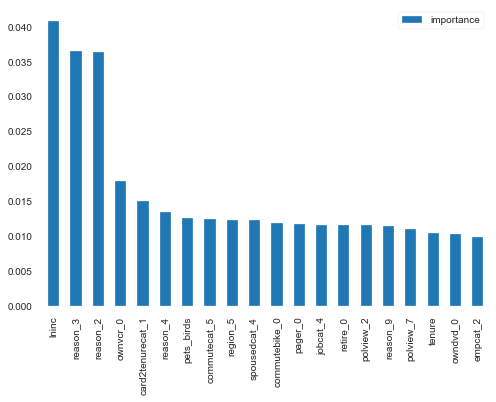

In [86]:
feature_importances_XG.head(20).plot(kind='bar')

### Conclusions:
- The most important factor in determining credit card spend is income and convenience of banking. 
- Service of the bank also plays an important role for the spend
- The prices offered by the bank is also deriving the spend
- The marketing strategies like checking the response of the customer has a valuable outcome and has impact on the spend
- Customers having job category in agricultural and natural resources can be targetted as this category has positive impact on credit card spend
- Customers prefer to bay ebills
- Customers having commute through motor vehicle are also prone to impact as a factor to derive the spend
- Customers using dialup internet and DSL can be targetted for building a new customer or providing extra services
- Other factors like gender, commute through bike and car also effects the credit card spend. 

### Recommendations & Next Steps
- Regular model rebuilding after specific time interval will be required for maintenance.
- The key drivers for the model are income and existing cards possessed by the customer.
- One should make sure that they remain consistent after certain time period. Any changes should be incorporated into the model and retrained accordingly.
- Also check should be performed if newer predictors can be found and helpful to have better prediction on the data.